# 1 SDS on AU 100 2x6x6 LAMMPS

This notebook contains a set of code snippets and functions, supporting analysis of LAMMPS output.
Exemplarily, the minimization, equilibration and production trajectories of one dodecyl sulfate ion in
the vicinity of a 100 gold layer are investigated.

With the help of numpy, pandas and matplotlib, LAMMPS output energy conbtributions are evaluated and plotted.
With the help of ase, parmed, nglview and ipywidgets, trajectories are visulized.

With the help of ase and asap, radial distribution functions, distances, displacements and diffusivities are evaluated.

## 1. Header

### 1.1. Jupyter Notebook-related "magic" commands

In [146]:
## preferred installation method for netcdf on NEMO locally:
# module load mpi/openmpi/2.1-gnu-5.2
# module load {...}
# export CPPFLAGS="${CPPFLAGS} -I${MPI_INC_DIR}"
# export LDFLAGS="${LDFLAGS} -L${MPI_LIB_DIR}"
# pip install --user netCDF4

## alternatively:
# pip install --user --global-option=build_ext --global-option="-L${MPI_INC_DIR}" netCDF4

In [147]:
%lsmagic # notebook commands

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %memit  %mkdir  %more  %mprun  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%memit  %%mprun  %%perl  

In [148]:
# list environment variables, like bash's 'printenv'
%env

{'BASH_FUNC_module()': '() {  eval $(/opt/bwhpc/common/admin/modules/module-wrapper/modulecmd bash $*)\n}',
 'CC': 'gcc',
 'CFLAGS': '-O3 -fPIC',
 'CLICOLOR': '1',
 'CMAKE_BIN_DIR': '/opt/bwhpc/common/devel/cmake/3.9.0/bin',
 'CMAKE_DOC_DIR': '/opt/bwhpc/common/devel/cmake/3.9.0/doc',
 'CMAKE_HOME': '/opt/bwhpc/common/devel/cmake/3.9.0',
 'CMAKE_MAN_DIR': '/opt/bwhpc/common/devel/cmake/3.9.0/man',
 'CMAKE_VERSION': '3.9.0',
 'CPATH': '/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_modules/lammps/16Mar18-gnu-5.2-openmpi-2.1/include:/opt/bwhpc/common/compiler/intel/2017.7.259/compilers_and_libraries/linux/mkl/include',
 'CPPFLAGS': '-I/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_modules/lammps/16Mar18-gnu-5.2-openmpi-2.1/include',
 'CXX': 'g++',
 'CXXFLAGS': '-O3 -fPIC',
 'C_INCLUDE_PATH': '/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_modules/libxc/2.2.0/include',
 'DISPLAY': 'localhost:21.0',
 'ENV': '/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17',
 'F77': 'gfortran',

In [4]:
%load_ext memory_profiler

In [5]:
# for some reason, nglview sometimes changes into some temporary directory
# therefore ALWAY use absolute filenames and paths
# %cd /work/ws/nemo/fr_jh1130-201708-0/jobs/lmplab/sds/201806/1_SDS_on_AU_100_1x4x4/

### 1.2. Imports

In [6]:
# system basics
import os
absolute_prefix = os.getcwd() # might be handy to get back to the initial working directory at any point
os.sep # '\' ond windows and '/' on unix-like

In [9]:
# data analysis 
import pandas as pd 
import numpy as np
import ase
from asap3.analysis.rdf import RadialDistributionFunction

# file formats, input - output
import ase.io
from ase.io import read
import parmed as pmd

# visualization
from ase.visualize import view
import nglview as nv
import matplotlib.pyplot as plt
import ipywidgets # just for jupyter notebooks

### 1.3. Global options

In [12]:
%matplotlib inline

In [13]:
# matplotlib settings

# expecially for presentation, larger font settings for plotting are recommendable
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titlex

plt.rcParams["figure.figsize"] = (11,7) # the standard figure size

In [293]:
# numpy truncates the output of large array above the treshold length
np.set_printoptions(threshold=10) 

### 1.4. Definition of helper functions

In [296]:
def fullprint(*args, **kwargs):
    """prints a long numpy array without altering numpy treshold options permanently"""
    from pprint import pprint
    opt = np.get_printoptions()
    np.set_printoptions(edgeitems=3,infstr='inf', 
        linewidth=75, nanstr='nan', precision=8,
        suppress=False, threshold=100000, formatter=None)
    pprint(*args, **kwargs)
    np.set_printoptions(**opt)

In [140]:
def runningMeanFast(x, N):
    """a quick way to compute the running or rolling mean on a numpy array"""
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

In [1042]:
def running_mean(x, N):
    """another quick way to compute the running or rolling mean on a numpy array"""
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [844]:
def subplotPosition(rows,cols):
    """generator for subplot positions"""
    for p in range(0,rows*cols):
        yield rows*100+cols*10+p+1

def addSubplot(x, y,
               title=None, xlabel=None, ylabel=None, legend=None,
               fig=None, ax=None, pos=None, figsize=(8,5)):
    """facilitate matplotlib figure & subplot creation. only one data series per call."""
    
    if not pos:
        pos = 111
    if not fig and not ax:
        fig = plt.figure(figsize=figsize)
    elif not fig and ax:
        fig = ax.get_figure()
    if not ax:
        ax = fig.add_subplot(pos)
      
    if legend:
        ax.plot(x,y,label=legend)
    else:
        ax.plot(x,y)
               
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
    if legend:
        ax.legend()
        
    return fig, ax

In [931]:
def makeThermoPlotsFromDataFrame(df, fig=None,
        time_label          = r'$\frac{\mathrm{Steps}}{2 \mathrm{fs}}$',
        temperature_label   = r'$\frac{T}{\mathrm{K}}$',
        pressure_label      = r'$\frac{P}{\mathrm{atm}}$',
        energy_label        = r'$\frac{E}{\mathrm{Kcal} \cdot \mathrm{mole}^{-1}}$'):
    """Automizes the plotting of thermo output."""

    rows = 3
    cols = 2
    if fig == None:
        fig = plt.figure(figsize=(cols*8,rows*5))
    
    def sublpotPosition(rows,cols):
        for p in range(0,rows*cols):
            yield rows*100+cols*10+p+1
     
    def addSubplot(df,fig,pos,title,xlabel,ylabel):
        ax = fig.add_subplot(pos)
        df.plot(ax=ax) # taimed temperature
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    
    pos = sublpotPosition(rows,cols)
    
    # sum up intramolecular contributions 
    df["E_intramolecular"] = df[["E_bond","E_angle","E_dihed"]].sum(axis=1)
    
    addSubplot(df[["Temp"]],
               fig, next(pos), "Temperature", time_label, temperature_label)
    addSubplot(df[["Press"]],
               fig, next(pos), "Pressure", time_label, pressure_label)
   
    # intramolecular contributions (without angle)
    addSubplot(df[["E_intramolecular","E_bond","E_angle","E_dihed"]],
               fig, next(pos), "Intramolecular energies", time_label, energy_label)
    # intermolecular ("non-bonded") energy contribtutions
    # E_pair is the sum of the three latter, just as E_intramolecular in the plot above
    addSubplot(df[["E_pair","E_vdwl","E_coul","E_long"]],
                fig, next(pos), "Intermolecular (non-bonded) energies", time_label, energy_label)
    
    # visualize the difference between total and non-bonded potential:
    addSubplot(df[["PotEng","E_pair"]],
               fig, next(pos), "Total potential and non-bonded potential", time_label, energy_label)
    
    addSubplot(df[["TotEng","KinEng","PotEng"]],
               fig, next(pos), "Total, kinetic and potential energies", time_label, energy_label)
    
    fig.tight_layout()
    return fig

In [932]:
def makeRollingAverageThermoPlotsFromDataFrame(df, fig=None,
        time_label          = r'$\frac{\mathrm{Steps}}{2 \mathrm{fs}}$',
        temperature_label   = r'$\frac{T}{\mathrm{K}}$',
        pressure_label      = r'$\frac{P}{\mathrm{atm}}$',
        energy_label        = r'$\frac{E}{\mathrm{Kcal} \cdot \mathrm{mole}^{-1}}$',
        window = 1000):
    """Automizes the plotting of thermo output. Displays the rolling average with default window = 1000."""
    
    rows = 3
    cols = 2
    if fig == None:
        fig = plt.figure(figsize=(cols*8,rows*5))
    
    def sublpotPosition(rows,cols):
        for p in range(0,rows*cols):
            yield rows*100+cols*10+p+1
     
    def addSubplot(df,fig,pos,title,xlabel,ylabel):
        ax = fig.add_subplot(pos)
        df.plot(ax=ax)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    
    pos = sublpotPosition(rows,cols)
    
    # sum up intramolecular contributions 
    df["E_intramolecular"] = df[["E_bond","E_angle","E_dihed"]].sum(axis=1)
    
    addSubplot(df[["Temp"]].rolling(window=window,center=True).mean(),
               fig, next(pos), "Temperature", time_label, temperature_label)
    addSubplot(df[["Press"]].rolling(window=window,center=True).mean(),
               fig, next(pos), "Pressure", time_label, pressure_label)
   
    # intramolecular contributions (without angle)
    addSubplot(
      df[["E_intramolecular","E_bond","E_angle","E_dihed"]].rolling(window=window,center=True).mean(),
      fig, next(pos), "Intramolecular energies", time_label, energy_label)
    # intermolecular ("non-bonded") energy contribtutions
    # E_pair is the sum of the three latter, just as E_intramolecular in the plot above
    addSubplot(df[["E_pair","E_vdwl","E_coul","E_long"]].rolling(window=window,center=True).mean(),
                fig, next(pos), "Intermolecular (non-bonded) energies", time_label, energy_label)
    
    # visualize the difference between total and non-bonded potential:
    addSubplot(df[["PotEng","E_pair"]].rolling(window=window,center=True).mean(),
               fig, next(pos), "Total potential and non-bonded potential", time_label, energy_label)
    
    addSubplot(df[["TotEng","KinEng","PotEng"]].rolling(window=window,center=True).mean(),
               fig, next(pos), "Total, kinetic and potential energies", time_label, energy_label)
    
    fig.tight_layout() # tigh_layout avoids label overlap
    return fig

In [959]:
# ASE by default infers elements from LAMMPS atom types, in our case they are unrelated
# During preprocessing, our system went through several formats, one of them the 
# archaic .pdb format. Although ASE offers a pdb reader, it fails on our system.

# On the other hand, ParmEd is able to read .pdb and infer elements more or less accurately,
# but cannot process netCDF. Thus we combine both:
def inferTypes2NumbersFromPdbAndLmp(pdb_file,lmp_data_file):
    struct_pdb_pmd = pmd.read_PDB(pdb_file)
    struct_lmp_data = ase.io.read(lmp_data_file,format='lammps-data')
    
    resnames = np.unique([r.name for r in struct_pdb_pmd.residues])
    print("PDB contains following residue types {}".format(resnames))
    
    ions = [ a for a in struct_pdb_pmd.atoms if a.residue.name == 'ION' ] # sodium counterions
    
    # small sodium correction: apparently, SOD and S are both interpreted as sulfur
    for ion in ions:
        if ion.atomic_number == 16: # wrong: inferred S (sulfur)
            ion.atomic_number = 11
            
    # elements numbered as in periodic table
    atomic_numbers = np.array([ a.atomic_number for a in struct_pdb_pmd.atoms ]) 
    atomic_types = struct_lmp_data.get_atomic_numbers() # types as numbered in LAMMPS
    types2numbers = dict(zip(atomic_types,atomic_numbers)) # automatically picks unique tuples
    
    print("System contains {:d} atom types.".format(len(types2numbers)))
    
    # construct array, where indices represent LAMMPS type numbers and point to atomic numbers
    types2numbers_array = np.zeros(atomic_types.max()+1,dtype=np.uint)

    for k,v in types2numbers.items():
        types2numbers_array[k] = v
        
    # this kind of array representation allows for simple type2number conversion via an expression like
    #   types2numbers_array[atomic_types]
    
    return types2numbers, types2numbers_array

## 2. Energy evaluations with pandas

In [14]:
dt = 2e-15 # s, 2 fs timestep

In [788]:
# conversion units, only for better readability
fs = 1e-15 # s
ps = 1e-12 # s

In [778]:
AA = 1e-10 # m

### 2.1 Minimization

In [149]:
%ls *minimization.log

1_SDS_on_AU_100_2x6x6_01_minimization.log


In [150]:
!./extract_thermo.sh *minimization.log 01_minimization_thermo.out

In [151]:
minimization_thermo_file = absolute_prefix + os.sep + '01_minimization_thermo.out'

In [152]:
minimization_thermo_pd = pd.read_csv(minimization_thermo_file,delim_whitespace=True)

In [153]:
minimization_thermo_pd.set_index("Step",inplace=True)

In [154]:
minimization_thermo_pd

TotEng  KinEng     PotEng  Temp       Press   Enthalpy      E_bond  \
Step                                                                          
0    -12008.118       0 -12008.118     0  -4867.3793 -13072.206   96.679213   
10   -12467.859       0 -12467.859     0 -20084.3590 -16858.628   26.373132   
20   -12547.395       0 -12547.395     0 -21258.2420 -17194.794   23.559249   
30   -12639.445       0 -12639.445     0 -20269.6590 -17070.723   28.090739   
40   -12738.236       0 -12738.236     0 -19047.0220 -16902.225   41.416781   
50   -12832.103       0 -12832.103     0 -17717.3890 -16705.413   52.228976   
60   -12948.284       0 -12948.284     0 -15655.3060 -16370.789   53.626682   
70   -13067.757       0 -13067.757     0 -16015.7310 -16569.056   67.498641   
80   -13186.473       0 -13186.473     0 -15475.5880 -16569.689   76.646073   
90   -13303.430       0 -13303.430     0 -14134.4060 -16393.442   84.490585   
100  -13399.324       0 -13399.324     0 -13484.6710 -16347.293   90.824754   
110  -13475.032       0 -13475.032     0 -13780.5910 -16487.693   95.641640   
120  -13534.458       0 -13534.458     0 -14080.2680 -16612.635   97.316226   
130  -13584.143       0 -13584.143     0 -13795.3740 -16600.037   99.593868   
140  -13624.854       0 -13624.854     0 -13571.0720 -16591.711  102.238310   
150  -13662.191       0 -13662.191     0 -13076.3590 -16520.896  103.445500   
160  -13696.632       0 -13696.632     0 -12755.5680 -16485.208  104.546570   
170  -13723.409       0 -13723.409     0 -12666.7000 -16492.556  106.560130   
180  -13746.294       0 -13746.294     0 -12409.3540 -16459.181  107.264390   
190  -13765.170       0 -13765.170     0 -12917.1410 -16589.068  108.380130   
200  -13780.648       0 -13780.648     0 -12701.2850 -16557.356  109.470740   
210  -13793.882       0 -13793.882     0 -12800.6500 -16592.313  109.232380   
220  -13806.695       0 -13806.695     0 -12631.3720 -16568.119  109.239760   
230  -13819.264       0 -13819.264     0 -12460.1800 -16543.263  110.025390   
240  -13830.798       0 -13830.798     0 -12098.7520 -16475.782  110.530910   
250  -13841.278       0 -13841.278     0 -12187.1280 -16505.583  111.223420   
260  -13850.616       0 -13850.616     0 -12178.0420 -16512.934  111.420160   
270  -13859.673       0 -13859.673     0 -12446.7010 -16580.725  111.390790   
280  -13868.666       0 -13868.666     0 -12684.3020 -16641.662  110.781330   
290  -13878.141       0 -13878.141     0 -12963.6810 -16712.213  110.706800   
...         ...     ...        ...   ...         ...        ...         ...   
560  -14030.081       0 -14030.081     0 -12021.0870 -16658.087  116.682010   
570  -14031.237       0 -14031.237     0 -12125.1670 -16681.996  116.571970   
580  -14032.240       0 -14032.240     0 -12162.4710 -16691.154  116.488690   
590  -14033.173       0 -14033.173     0 -12192.7540 -16698.707  116.528180   
600  -14034.019       0 -14034.019     0 -12138.7810 -16687.754  116.796320   
610  -14035.011       0 -14035.011     0 -12145.9990 -16690.324  116.727110   
620  -14036.227       0 -14036.227     0 -12147.3840 -16691.844  116.418840   
630  -14037.389       0 -14037.389     0 -12104.4210 -16683.613  116.279820   
640  -14038.750       0 -14038.750     0 -11973.0970 -16656.264  116.095560   
650  -14040.570       0 -14040.570     0 -11829.1250 -16626.610  116.262600   
660  -14042.439       0 -14042.439     0 -11723.2930 -16605.341  116.642630   
670  -14044.104       0 -14044.104     0 -11673.5360 -16596.129  116.745200   
680  -14045.783       0 -14045.783     0 -11706.8820 -16605.098  116.830220   
690  -14047.713       0 -14047.713     0 -11758.2680 -16618.262  117.113310   
700  -14049.829       0 -14049.829     0 -11799.6420 -16629.423  117.635770   
710  -14051.767       0 -14051.767     0 -11873.9390 -16647.603  117.524120   
720  -14053.802       0 -14053.802     0 -11799.1560 -16633.290  117.504060   
730  -14056.234       0 -14056.234     0 -11740.6100 -16622

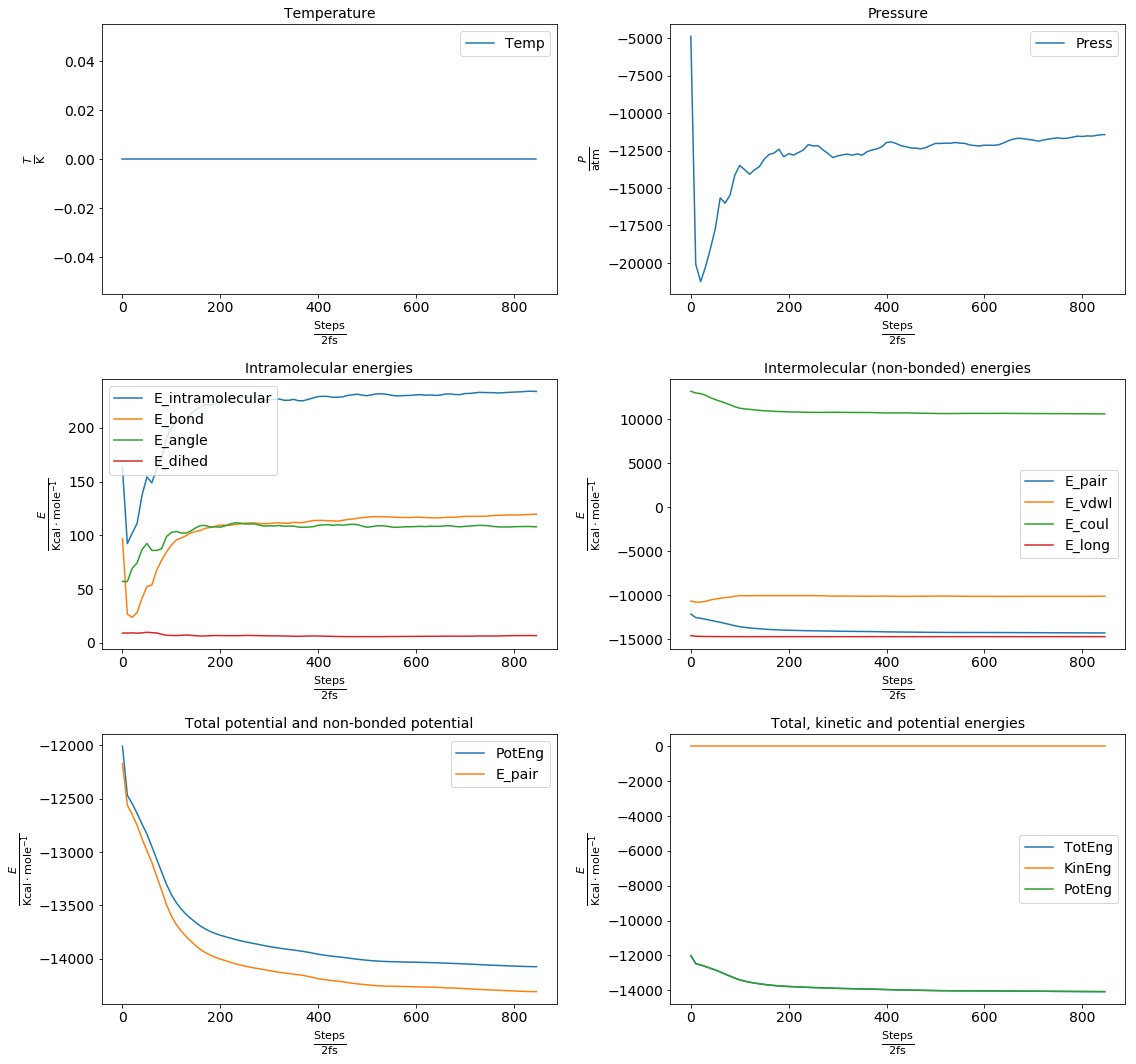

In [933]:
makeThermoPlotsFromDataFrame(minimization_thermo_pd);

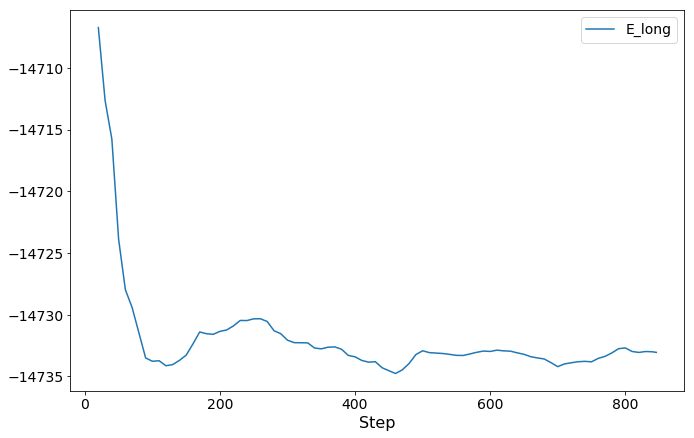

In [896]:
minimization_thermo_pd[["E_long"]][2:].plot()

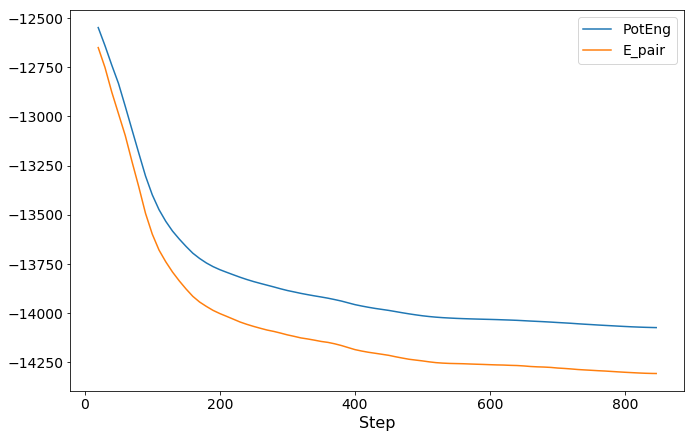

In [897]:
# The total energy decreases, but intramolecular energy increases during minimization:
minimization_thermo_pd[["PotEng","E_pair"]][2:].plot()

In [898]:
# double-check: total potential energy of system minus non-bonded energy (LJ & Coulomb) 
# should correspond to intramolecular energy:
intramolecularEnergyValidation = minimization_thermo_pd["PotEng"] - minimization_thermo_pd["E_pair"]

In [899]:
intramolecularEnergyValidationDiff = (intramolecularEnergyValidation - minimization_thermo_pd["E_intramolecular"])

In [900]:
intramolecularEnergyValidationDiff.max()

0.00090870000182974309

In [901]:
intramolecularEnergyValidationDiff.abs().max() / intramolecularEnergyValidation.min()

1.0282848887844876e-05

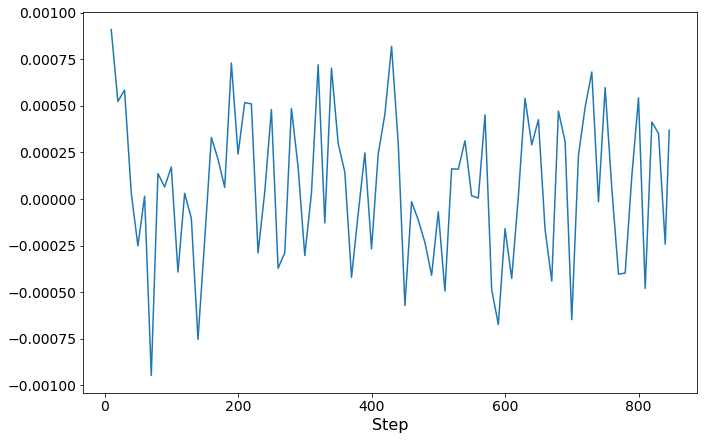

In [902]:
(intramolecularEnergyValidation - minimization_thermo_pd["E_intramolecular"])[1:].plot()
# obviously "equal" (up to a tiny fraction)

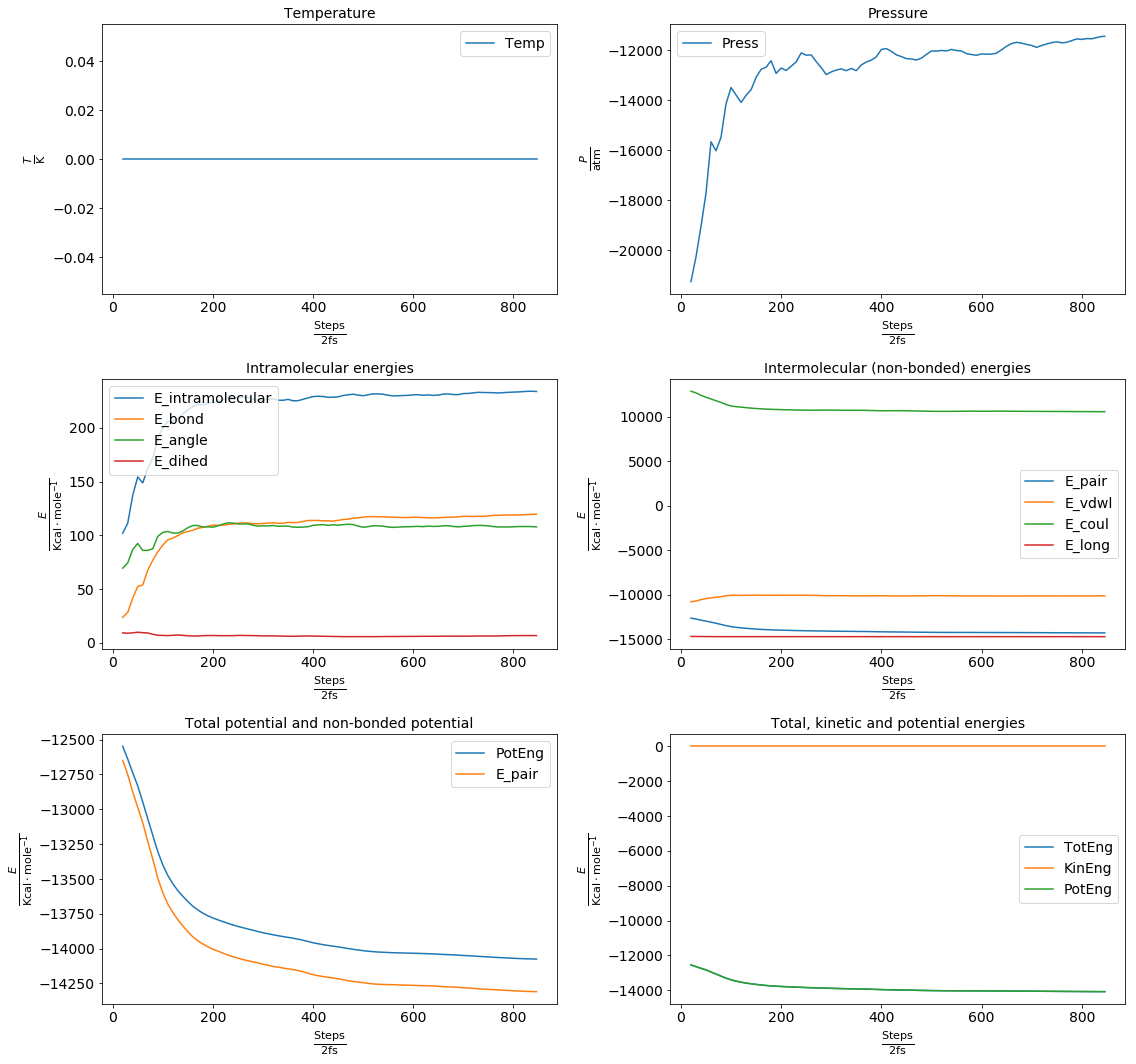

In [903]:
# descent to steep t the first few steps, excluded
makeThermoPlotsFromDataFrame(minimization_thermo_pd.iloc[2:].copy())

### 2.2. NVT equilibration

In [904]:
!./extract_thermo.sh *nvtEquilibration.log 02_nvtEquilibration_thermo.out

In [905]:
nvtEquilibration_thermo_file = absolute_prefix + os.sep + '02_nvtEquilibration_thermo.out'

In [906]:
nvtEquilibration_thermo_pd = pd.read_csv(nvtEquilibration_thermo_file,delim_whitespace=True)

In [907]:
nvtEquilibration_thermo_pd.set_index("Step",inplace=True)

In [908]:
nvtEquilibration_thermo_pd

TotEng      KinEng     PotEng       Temp         Press   Enthalpy  \
Step                                                                         
0    -13694.684   590.91954 -14285.604  229.53446  -9562.887600 -15785.287   
10   -13272.799   366.71668 -13639.516  142.44598  -5560.567200 -14488.430   
20   -13254.257   320.20237 -13574.460  124.37815  -4396.088600 -14215.314   
30   -13225.089   296.04282 -13521.131  114.99371  -4006.791000 -14101.038   
40   -13181.251   302.94605 -13484.197  117.67517  -4610.443700 -14189.169   
50   -13116.145   358.91026 -13475.056  139.41369  -5795.939800 -14383.232   
60   -13019.758   438.17985 -13457.938  170.20485  -6622.407400 -14467.524   
70   -12889.153   505.86666 -13395.019  196.49685  -6725.490200 -14359.454   
80   -12730.217   572.10631 -13302.323  222.22672  -5515.753000 -13936.051   
90   -12529.805   655.30940 -13185.114  254.54580  -4930.462300 -13607.684   
100  -12282.089   830.19383 -13112.283  322.47722  -5239.713700 -13427.576   
110  -11976.979  1032.55790 -13009.537  401.08272  -3669.716300 -12779.239   
120  -11645.785  1185.45790 -12831.243  460.47458  -2220.726000 -12131.272   
130  -11326.496  1305.14160 -12631.637  506.96407     26.289845 -11320.748   
140  -11056.092  1398.95180 -12455.044  543.40332   1725.434100 -10678.884   
150  -10860.206  1494.53560 -12354.742  580.53153     94.089491 -10839.636   
160  -10765.946  1525.83550 -12291.781  592.68952  -1421.788000 -11076.772   
170  -10793.799  1498.80130 -12292.600  582.18846  -2841.790400 -11415.060   
180  -10925.685  1349.95950 -12275.645  524.37294  -4675.910300 -11947.916   
190  -11110.235  1153.00000 -12263.235  447.86677  -5356.369500 -12281.224   
200  -11318.045  1007.82790 -12325.873  391.47672  -7532.964500 -12964.874   
210  -11529.682   914.15277 -12443.835  355.08990 -10114.895000 -13740.963   
220  -11731.735   806.62876 -12538.363  313.32370 -11925.006000 -14338.735   
230  -11918.352   745.57280 -12663.925  289.60736 -14648.503000 -15120.754   
240  -12083.689   668.09914 -12751.788  259.51380 -15891.705000 -15557.874   
250  -12228.219   611.01331 -12839.232  237.33960 -16539.865000 -15844.103   
260  -12351.205   554.30601 -12905.511  215.31244 -16792.755000 -16022.375   
270  -12452.400   524.99879 -12977.399  203.92846 -16364.624000 -16029.974   
280  -12538.027   502.32445 -13040.351  195.12093 -15885.960000 -16010.957   
290  -12606.816   495.80074 -13102.617  192.58689 -15578.145000 -16012.452   
...         ...         ...        ...        ...           ...        ...   
2210 -12338.213   791.82728 -13130.041  307.57427  -5009.223500 -13433.311   
2220 -12334.217   804.97054 -13139.187  312.67959  -5372.844900 -13508.808   
2230 -12333.001   787.10602 -13120.107  305.74036  -5650.697400 -13568.335   
2240 -12333.262   791.09307 -13124.355  307.28907  -5599.464900 -13557.396   
2250 -12334.426   760.09502 -13094.521  295.24831  -5444.919400 -13524.774   
2260 -12336.007   750.17340 -13086.180  291.39440  -5442.438300 -13525.812   
2270 -12336.231   773.32071 -13109.552  300.38565  -5847.037100 -13614.489   
2280 -12336.665   783.71099 -13120.376  304.42161  -6739.088800 -13809.939   
2290 -12339.398   791.89865 -13131.297  307.60199  -7212.948800 -13916.266   
2300 -12343.156   770.57667 -13113.733  299.31977  -6985.824500 -13870.371   
2310 -12348.266   785.89579 -13134.162  305.27026  -7222.325800 -13927.184   
2320 -12354.106   755.92471 -13110.030  293.62841  -6396.523600 -13752.490   
2330 -12359.637   789.19140 -13148.828  306.55040  -6465.671400 -13773.138   
2340 -12366.147   769.93073 -13136.077  299.06886  -5817.293100 -13637.902   
2350 -12373.604   744.41288 -13118.017  289.15681  -4614.542700 -13382.418   
2360 -12379.384   757.49256 -13136.877  294.23742  -4774.381400 -13423.142   
2370 -12383.815   762.54311 -13146.358  296.19924  -4912.468000 -13457.761   
2380 -12387.827   778.12645 -13165.954  302.25237  -5178.109200 -13519.846   
2390 -12392.810   765.90526 -13

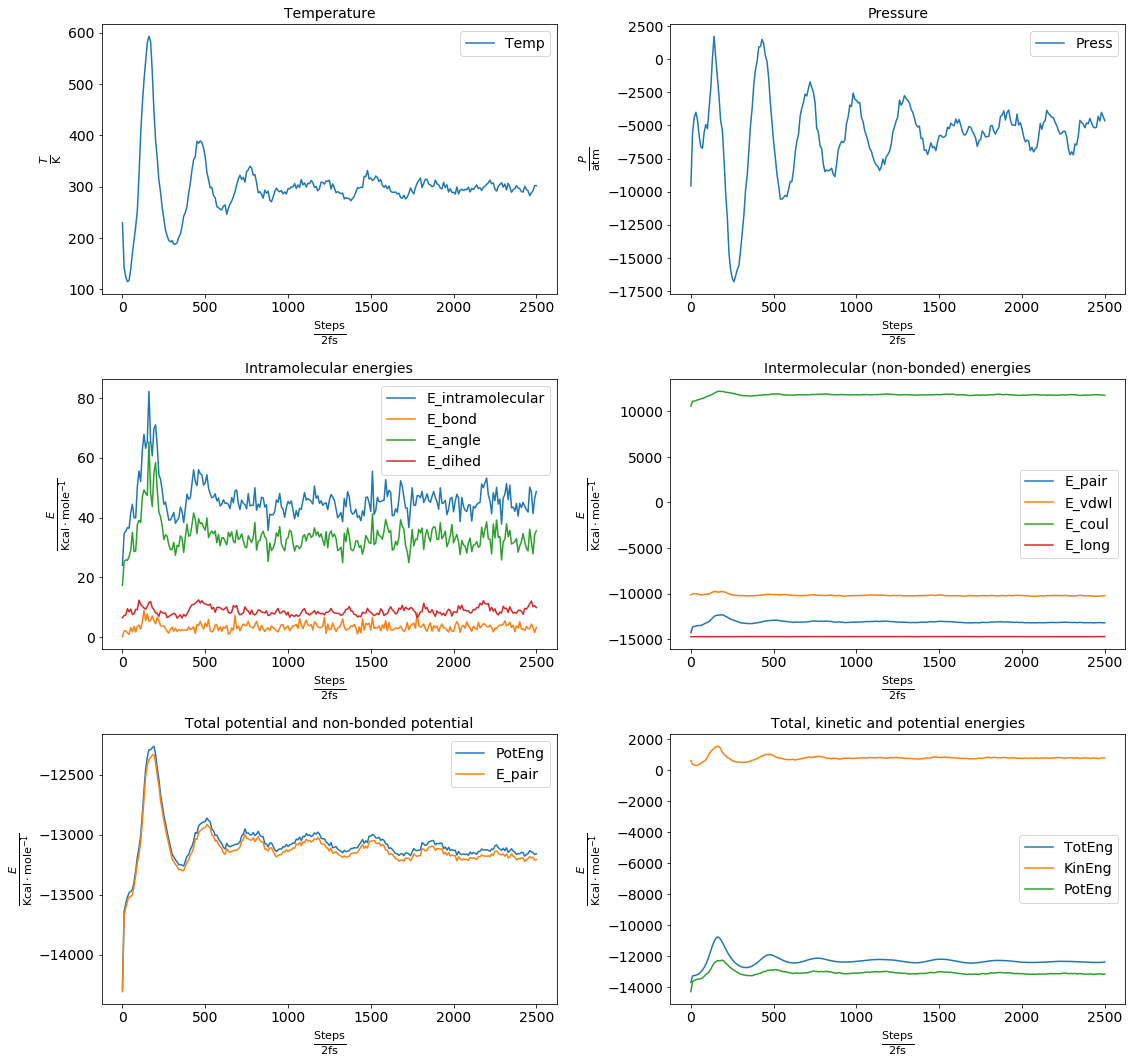

In [909]:
makeThermoPlotsFromDataFrame(nvtEquilibration_thermo_pd)

### 2.3. NPT equilibration

In [910]:
!./extract_thermo.sh *nptEquilibration.log 03_nptEquilibration_thermo.out

In [911]:
nptEquilibration_thermo_file = absolute_prefix + os.sep + '03_nptEquilibration_thermo.out'

In [912]:
nptEquilibration_thermo_pd = pd.read_csv(nptEquilibration_thermo_file,delim_whitespace=True)

In [913]:
nptEquilibration_thermo_pd.set_index("Step",inplace=True)

In [914]:
nptEquilibration_thermo_pd

TotEng     KinEng     PotEng       Temp        Press   Enthalpy  \
Step                                                                       
2500 -12382.818  777.34952 -13160.167  301.95058 -4642.537000 -13397.752   
2510 -12395.476  773.48461 -13168.961  300.44932  1740.888100 -12020.590   
2520 -12383.506  809.15418 -13192.660  314.30466  1942.586300 -11966.151   
2530 -12394.624  797.60432 -13192.228  309.81828 -2106.210300 -12849.769   
2540 -12407.525  816.00211 -13223.527  316.96465    73.156105 -12391.828   
2550 -12415.707  797.36616 -13213.073  309.72577   949.469050 -12212.719   
2560 -12431.162  774.12423 -13205.286  300.69776  -486.909150 -12535.419   
2570 -12448.158  737.40223 -13185.560  286.43361  -466.303650 -12547.940   
2580 -12458.875  766.19251 -13225.068  297.61680   806.500100 -12287.328   
2590 -12470.144  775.97608 -13246.120  301.41709  -558.138910 -12588.787   
2600 -12486.385  759.22843 -13245.613  294.91170  -507.346630 -12593.945   
2610 -12496.390  769.84006 -13266.231  299.03364  1065.559100 -12272.068   
2620 -12508.573  744.92770 -13253.501  289.35678  -486.784040 -12611.191   
2630 -12522.550  739.21703 -13261.767  287.13855  -202.379510 -12565.130   
2640 -12528.948  735.60659 -13264.555  285.73612   640.323010 -12394.791   
2650 -12535.783  761.40060 -13297.184  295.75545  -554.341970 -12651.868   
2660 -12544.204  772.59933 -13316.803  300.10544  -200.844600 -12586.114   
2670 -12549.345  730.53829 -13279.884  283.76741   585.716740 -12427.289   
2680 -12550.332  730.83679 -13281.169  283.88336    16.722193 -12546.848   
2690 -12553.522  710.26508 -13263.788  275.89257 -1216.937400 -12807.724   
2700 -12549.490  721.83624 -13271.326  280.38722  1525.570400 -12233.160   
2710 -12538.649  721.37821 -13260.027  280.20931   -86.220859 -12556.611   
2720 -12532.453  731.78708 -13264.240  284.25249  -809.251690 -12701.124   
2730 -12519.869  735.32378 -13255.193  285.62627   494.813760 -12416.951   
2740 -12502.604  740.14239 -13242.746  287.49799   671.291890 -12362.917   
2750 -12486.513  775.07878 -13261.592  301.06855  -825.564940 -12658.868   
2760 -12473.722  779.50003 -13253.222  302.78592  -371.439650 -12551.242   
2770 -12455.149  788.06057 -13243.210  306.11114  1396.727000 -12164.341   
2780 -12439.398  782.67204 -13222.070  304.01804  -256.650300 -12493.102   
2790 -12431.686  773.33676 -13205.023  300.39188 -1114.960100 -12665.979   
...         ...        ...        ...        ...          ...        ...   
4710 -12490.192  780.05187 -13270.243  303.00028 -1362.763300 -12777.442   
4720 -12489.555  775.63997 -13265.195  301.28653  1403.888800 -12195.161   
4730 -12489.320  783.20297 -13272.523  304.22428   679.266100 -12346.560   
4740 -12496.174  736.92308 -13233.097  286.24750 -1155.195200 -12740.273   
4750 -12500.492  738.32583 -13238.818  286.79238    20.658263 -12496.134   
4760 -12497.113  746.23816 -13243.351  289.86581   738.469160 -12341.490   
4770 -12495.333  775.37217 -13270.705  301.18251  -788.907920 -12662.022   
4780 -12496.818  793.32971 -13290.148  308.15787  -209.475660 -12540.997   
4790 -12493.949  772.85757 -13266.807  300.20575   365.541370 -12416.753   
4800 -12493.062  766.63685 -13259.699  297.78940   186.386910 -12453.661   
4810 -12493.717  743.87664 -13237.594  288.94851  -167.726170 -12529.223   
4820 -12493.030  792.87581 -13285.906  307.98156    93.657766 -12473.223   
4830 -12493.905  764.94109 -13258.846  297.13070   101.417230 -12472.447   
4840 -12493.797  764.14574 -13257.943  296.82176  -528.561220 -12605.853   
4850 -12496.695  728.14149 -13224.837  282.83641  -220.451990 -12543.461   
4860 -12487.942  762.26432 -13250.207  296.09095  1168.492800 -12241.089   
4870 -12485.904  775.06295 -13260.967  301.06240 -1145.062700 -12728.962   
4880 -12486.989  777.26145 -13264.251  301.91637   114.962380 -12462.642   
4890 -12477.305  745.17002 -13222.475  289.45091   968.766450 -12272.249   
4900 -12475.429  756.87100 -13232.300  293.99599 -1023.38

In [915]:
equilibration_pd = pd.concat([nvtEquilibration_thermo_pd,nptEquilibration_thermo_pd])

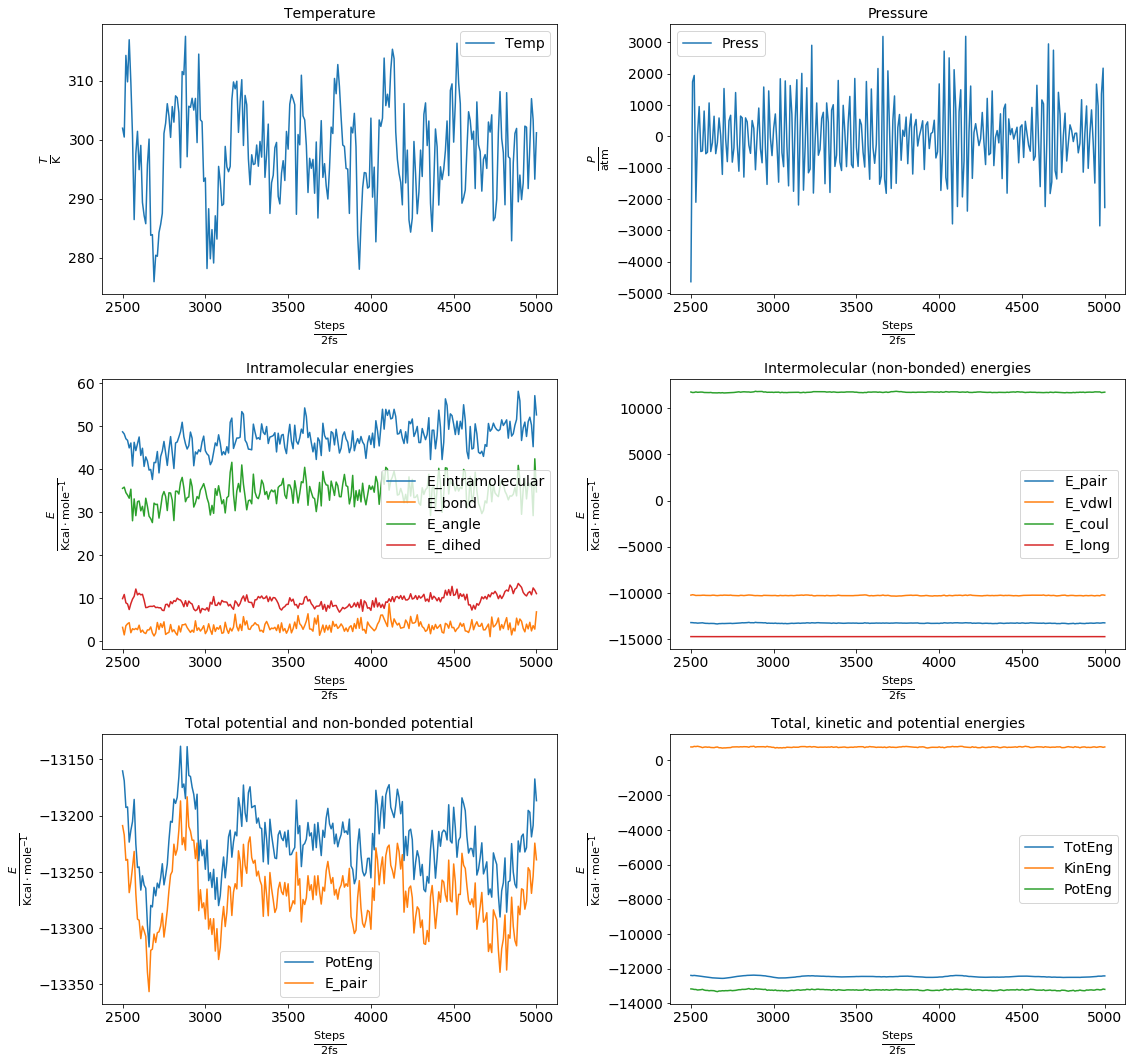

In [916]:
makeThermoPlotsFromDataFrame(nptEquilibration_thermo_pd)

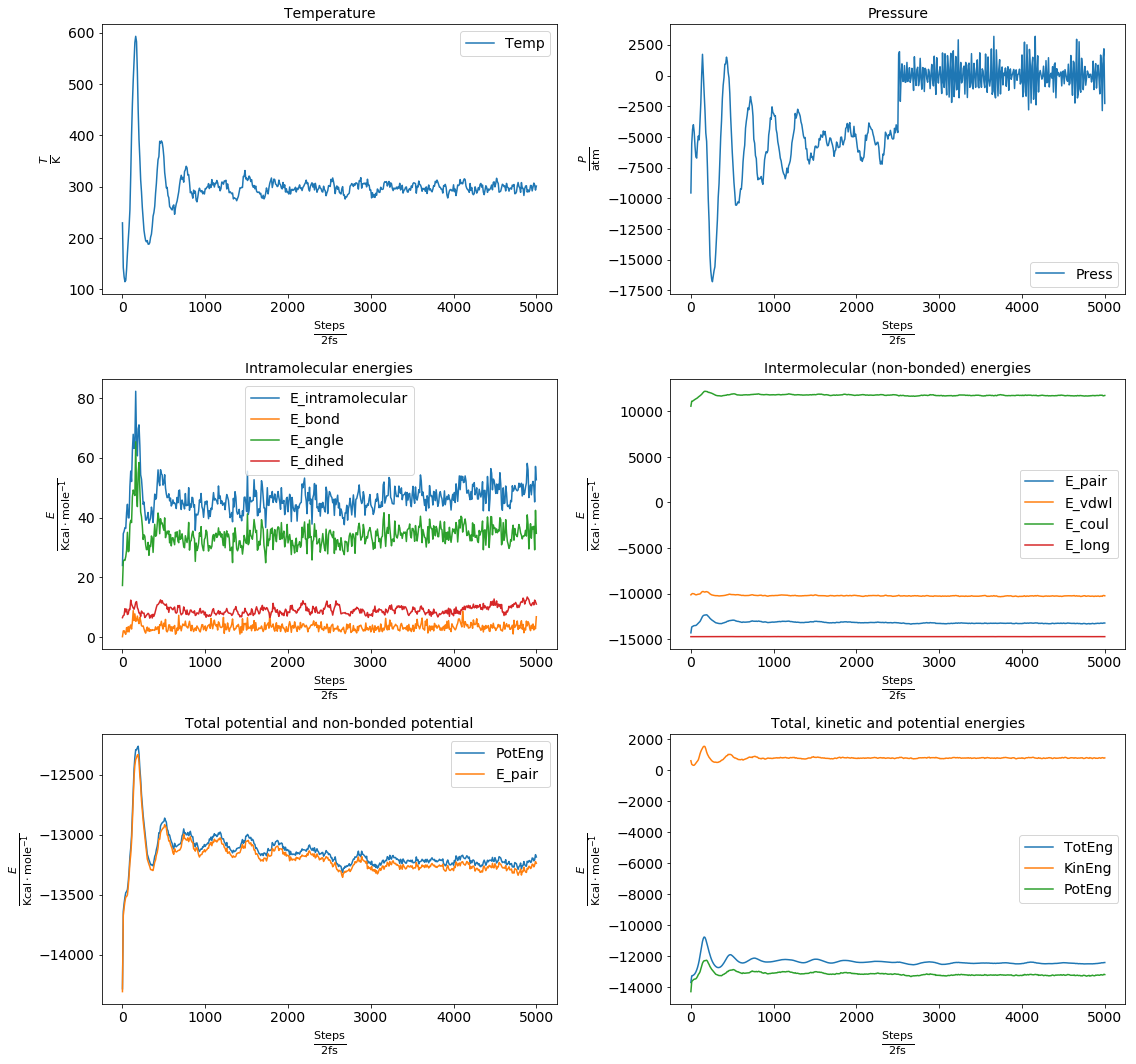

In [917]:
# show nvt and npt equilibration consecutively
makeThermoPlotsFromDataFrame(equilibration_pd)

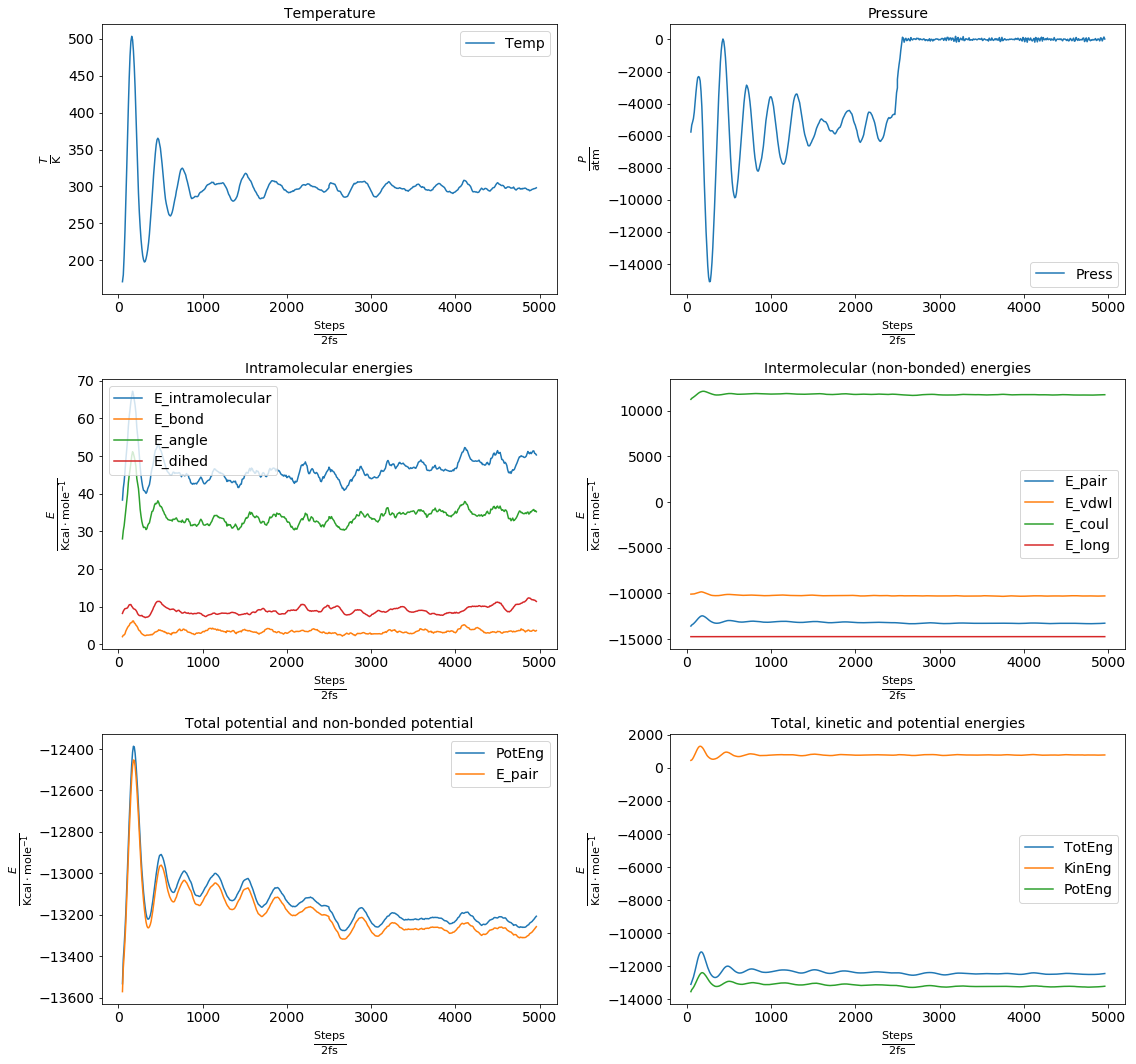

In [920]:
makeRollingAverageThermoPlotsFromDataFrame(equilibration_pd,window=10);

### 2.4. 10 ps NPT

In [921]:
!./extract_thermo.sh *_10ps_npt_01_nptProduction.log 05_10ps_nptProduction_thermo.out

In [934]:
nptProduction10ps_thermo_file = absolute_prefix + os.sep + '05_10ps_nptProduction_thermo.out'

In [935]:
nptProduction10ps_thermo_pd = pd.read_csv(nptProduction10ps_thermo_file,delim_whitespace=True)

In [936]:
nptProduction10ps_thermo_pd.set_index("Step",inplace=True)

In [937]:
nptProduction10ps_thermo_pd

TotEng     KinEng     PotEng       Temp        Press   Enthalpy  \
Step                                                                       
0    -12411.300  775.34385 -13186.644  301.17151 -2627.898500 -12971.365   
10   -12419.616  793.72663 -13213.343  308.31205   153.896370 -12387.004   
20   -12416.660  775.87342 -13192.533  301.37722  2189.406000 -11954.613   
30   -12418.765  782.24505 -13201.010  303.85218 -1215.198700 -12676.687   
40   -12434.195  789.03770 -13223.232  306.49070 -1597.146800 -12773.405   
50   -12435.122  757.45047 -13192.573  294.22108  2196.544200 -11971.923   
60   -12436.866  796.19772 -13233.064  309.27191   -89.291993 -12455.754   
70   -12452.289  770.09449 -13222.383  299.13247 -1473.806300 -12764.952   
80   -12458.311  780.47736 -13238.788  303.16555   896.128560 -12269.187   
90   -12465.461  758.78226 -13224.243  294.73839   288.183790 -12404.532   
100  -12473.789  769.83094 -13243.620  299.03010  -197.495310 -12515.494   
110  -12484.593  758.70741 -13243.301  294.70932  -846.205310 -12663.308   
120  -12493.188  771.12714 -13264.316  299.53359   592.235050 -12368.585   
130  -12498.521  754.58090 -13253.102  293.10643   414.319890 -12411.390   
140  -12509.535  759.25520 -13268.791  294.92210  -809.755060 -12680.252   
150  -12516.923  733.83129 -13250.755  285.04653   597.678950 -12391.365   
160  -12518.270  729.37223 -13247.642  283.31448   217.106320 -12472.651   
170  -12522.545  744.85867 -13267.404  289.32997  -658.846750 -12661.023   
180  -12523.140  765.96892 -13289.109  297.52995   221.697240 -12476.666   
190  -12522.336  760.86380 -13283.199  295.54693   438.223560 -12430.359   
200  -12520.042  755.14616 -13275.188  293.32600  -201.954500 -12562.531   
210  -12519.971  749.35221 -13269.323  291.07542  -293.719070 -12581.771   
220  -12516.075  760.66010 -13276.735  295.46781   682.151240 -12372.830   
230  -12512.386  751.64243 -13264.028  291.96502  -445.541220 -12606.148   
240  -12513.376  749.99178 -13263.368  291.32385   -95.283278 -12533.416   
250  -12504.639  736.91453 -13241.554  286.24417   344.908370 -12432.079   
260  -12501.182  761.29121 -13262.473  295.71296  -474.178940 -12601.128   
270  -12493.068  765.23080 -13258.298  297.24324   129.180710 -12465.858   
280  -12484.282  761.21127 -13245.493  295.68191   276.080020 -12426.154   
290  -12475.527  753.49097 -13229.018  292.68306  -342.303410 -12547.714   
...         ...        ...        ...        ...          ...        ...   
4710 -12423.973  798.78501 -13222.758  310.27690  -743.959400 -12581.139   
4720 -12421.703  808.46273 -13230.166  314.03608  1880.069300 -12027.016   
4730 -12420.852  797.56693 -13218.419  309.80375  -590.510260 -12545.366   
4740 -12434.934  773.41204 -13208.346  300.42113 -1545.928500 -12761.509   
4750 -12435.729  780.08080 -13215.809  303.01151  1918.574700 -12033.733   
4760 -12441.174  771.70420 -13212.878  299.75774  -857.960350 -12622.248   
4770 -12452.029  761.71159 -13213.741  295.87625   184.640050 -12413.213   
4780 -12454.258  737.18167 -13191.440  286.34794   472.610130 -12354.826   
4790 -12460.465  786.95771 -13247.423  305.68275  -508.706700 -12567.650   
4800 -12466.283  779.98476 -13246.267  302.97421    60.383124 -12453.580   
4810 -12472.386  753.45421 -13225.840  292.66879  -102.105210 -12493.920   
4820 -12477.125  749.40628 -13226.531  291.09642   648.887260 -12340.470   
4830 -12479.725  775.20227 -13254.927  301.11652  -693.919220 -12626.158   
4840 -12490.243  763.62363 -13253.866  296.61895    88.924501 -12471.538   
4850 -12489.395  744.86059 -13234.256  289.33071  1143.651600 -12249.230   
4860 -12495.447  746.02116 -13241.468  289.78152 -1191.480000 -12746.701   
4870 -12502.139  775.09967 -13277.239  301.07666   -45.210769 -12511.640   
4880 -12501.239  780.56390 -13281.803  303.19916   948.078160 -12302.196   
4890 -12506.563  745.81993 -13252.383  289.70336 -1096.274900 -12738.312   
4900 -12511.566  763.29520 -13274.861  296.49138   854.61

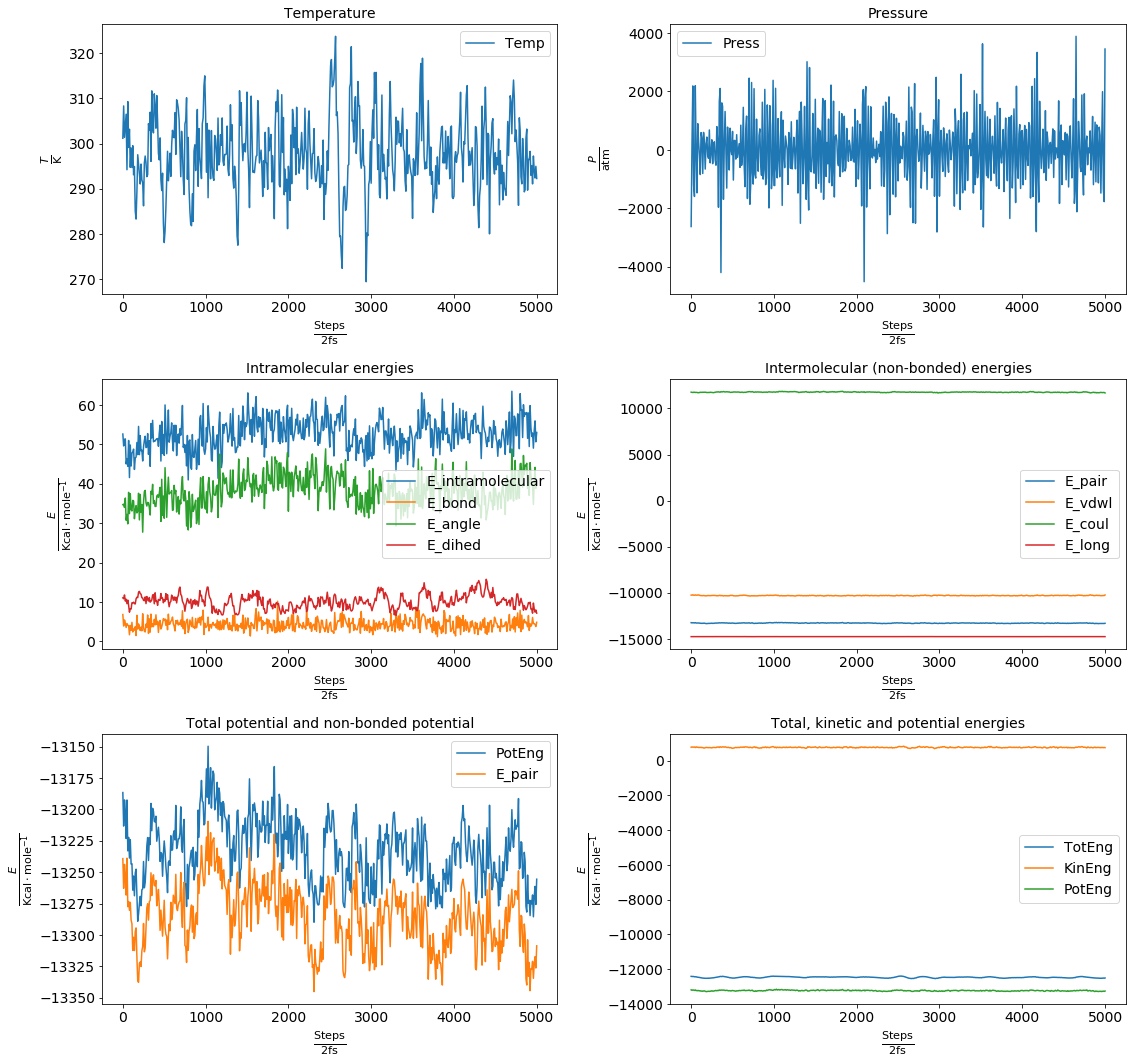

In [942]:
makeThermoPlotsFromDataFrame(nptProduction10ps_thermo_pd);

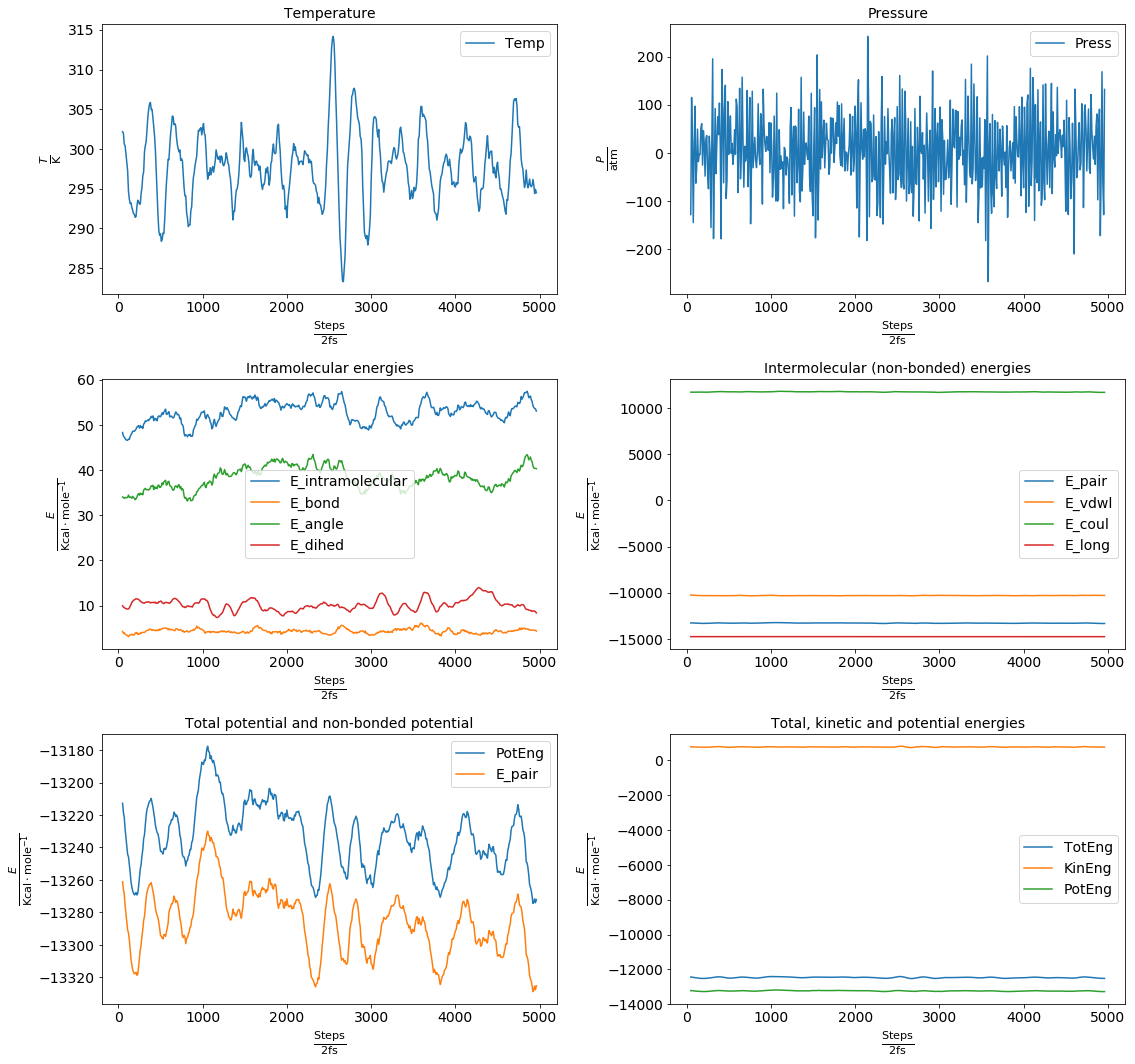

In [945]:
makeRollingAverageThermoPlotsFromDataFrame(nptProduction10ps_thermo_pd,window=10);

### 2.5. 100 ps NPT

In [946]:
!./extract_thermo.sh *_100ps_npt_01_nptProduction.log 05_100ps_nptProduction_thermo.out

In [947]:
nptProduction_100ps_thermo_file = absolute_prefix + os.sep + '05_100ps_nptProduction_thermo.out'
nptProduction_100ps_thermo_pd = pd.read_csv(nptProduction_100ps_thermo_file,delim_whitespace=True)
nptProduction_100ps_thermo_pd.set_index("Step",inplace=True)

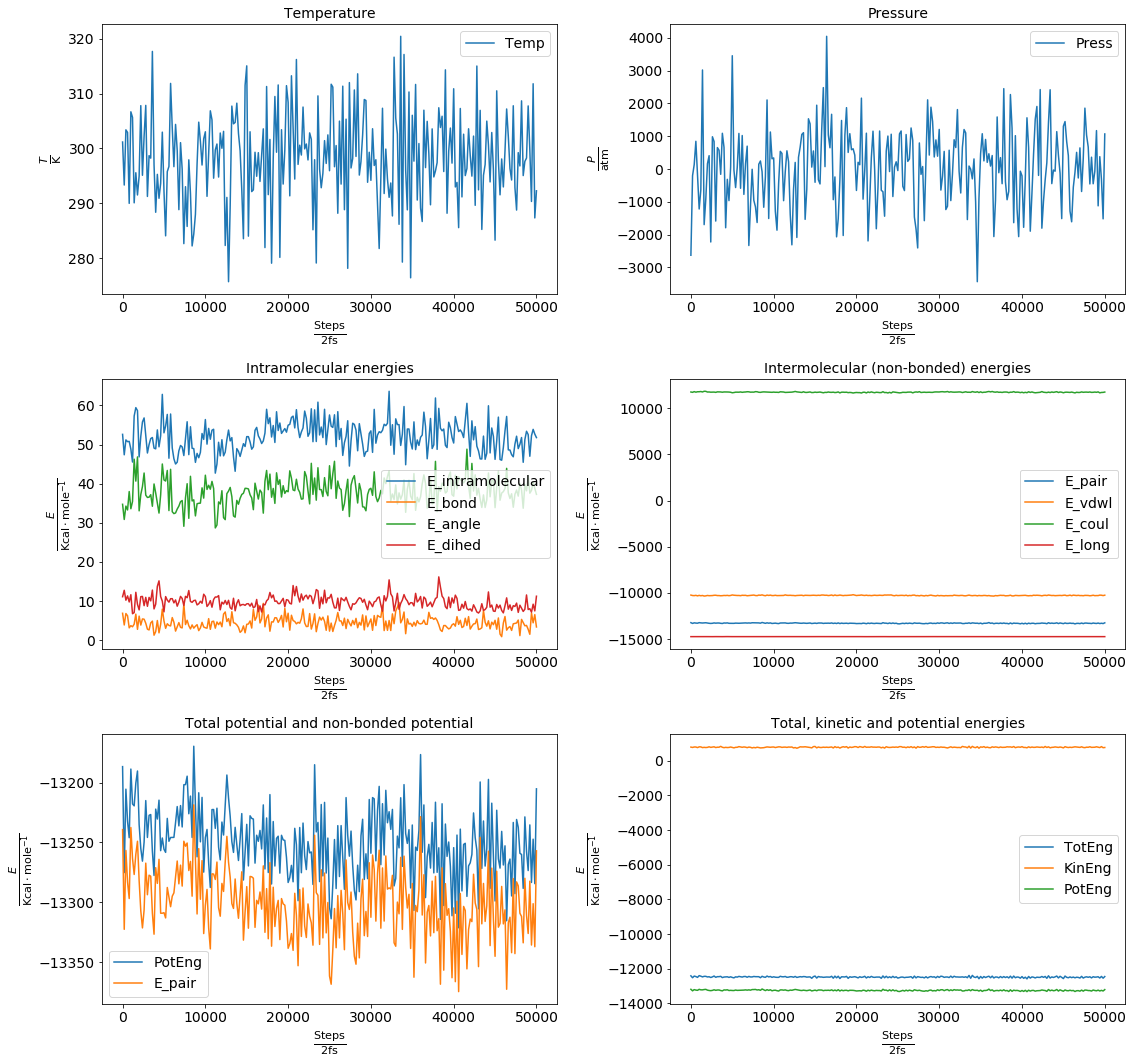

In [950]:
makeThermoPlotsFromDataFrame(nptProduction_100ps_thermo_pd.iloc[::20].copy()); # only every 20th data point

### 2.6. 1 ns NPT

In [951]:
!./extract_thermo.sh *_1ns_npt_01_nptProduction.log 05_1ns_nptProduction_thermo.out

In [952]:
nptProduction_1ns_thermo_file = absolute_prefix + os.sep + '05_1ns_nptProduction_thermo.out'
nptProduction_1ns_thermo_pd = pd.read_csv(nptProduction_1ns_thermo_file,delim_whitespace=True)
nptProduction_1ns_thermo_pd.set_index("Step",inplace=True)

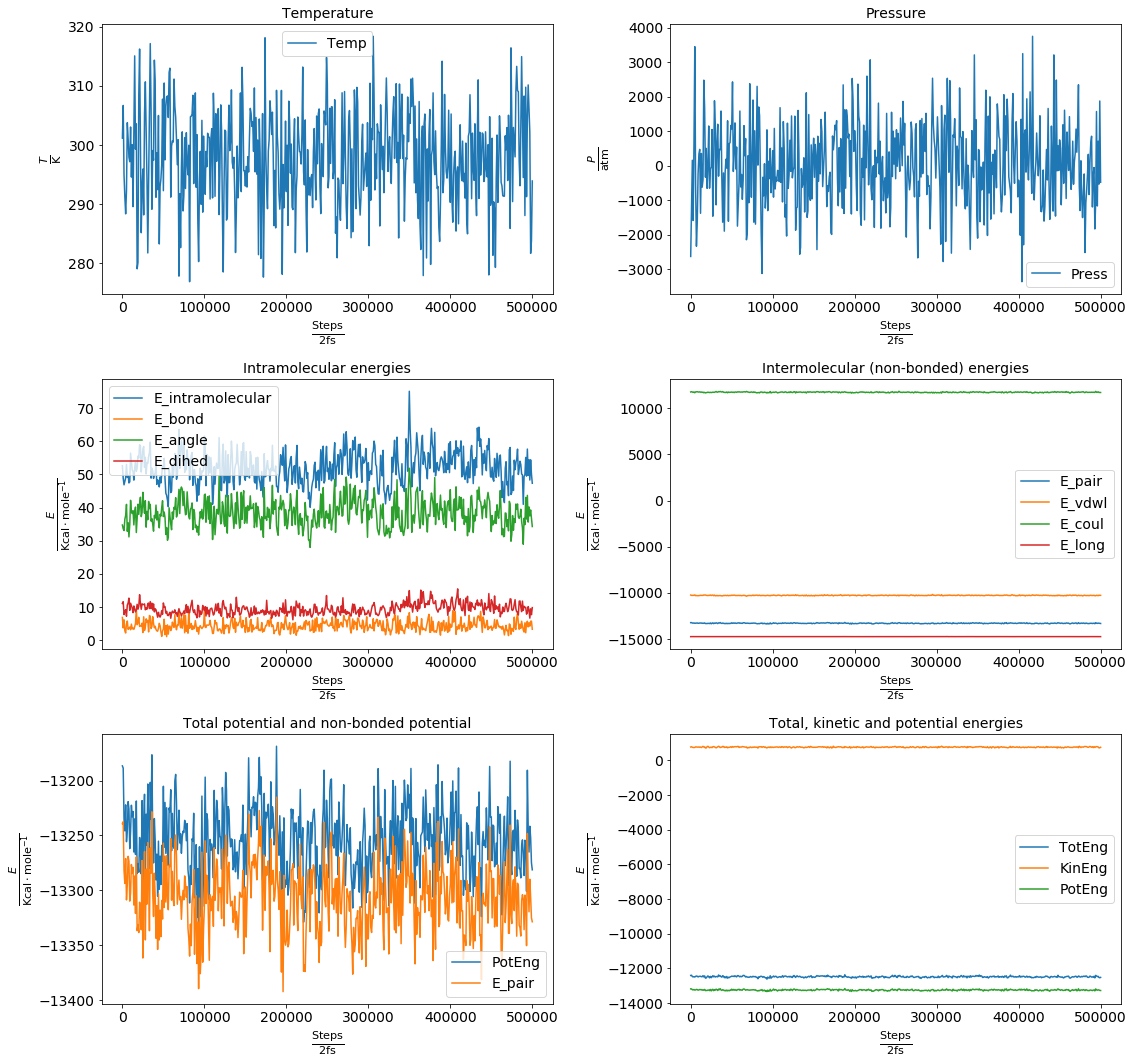

In [953]:
makeThermoPlotsFromDataFrame(nptProduction_1ns_thermo_pd.iloc[::100].copy()); # only every 100th data point

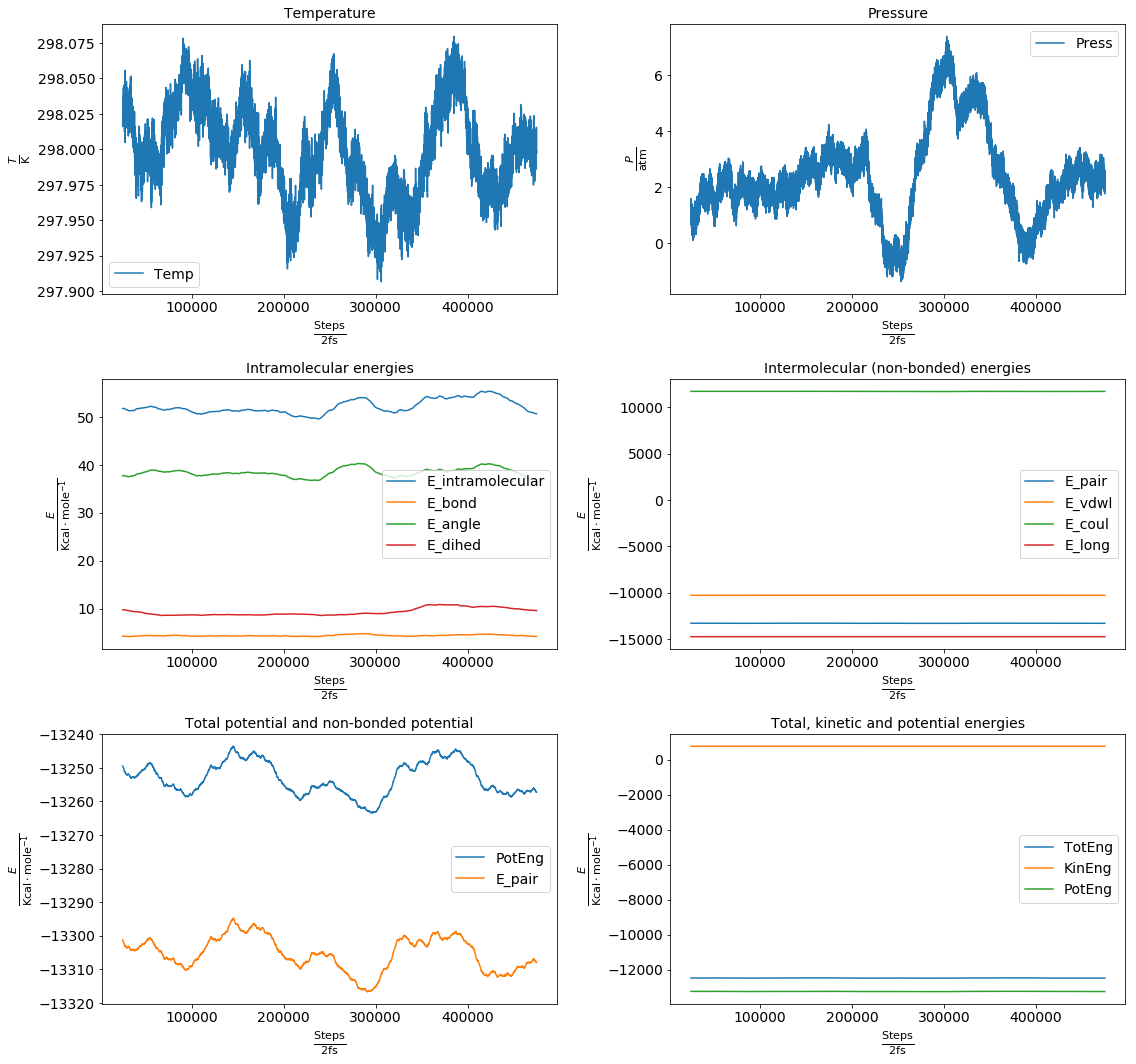

In [955]:
makeRollingAverageThermoPlotsFromDataFrame(nptProduction_1ns_thermo_pd,window=5000);

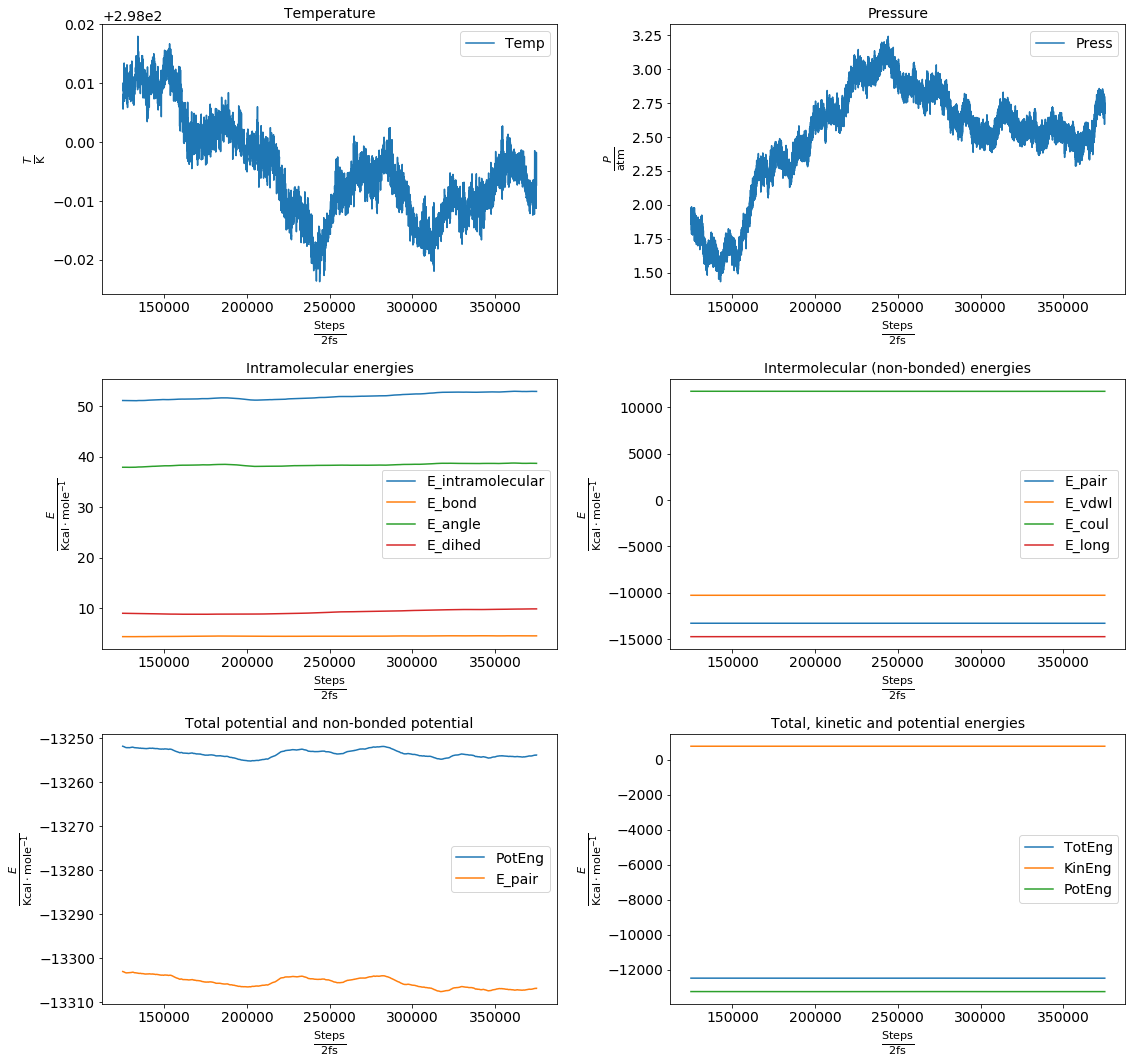

In [957]:
makeRollingAverageThermoPlotsFromDataFrame(nptProduction_1ns_thermo_pd,window=25000);

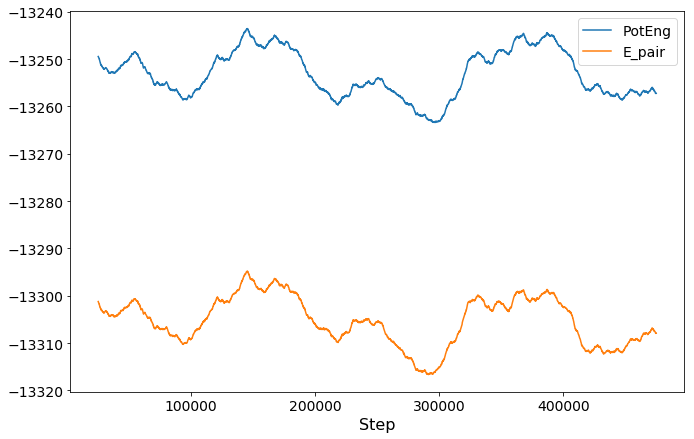

In [958]:
nptProduction_1ns_thermo_pd[["PotEng","E_pair"]].rolling(window=5000,center=True).mean().plot()

## 3. Trajectory visualization with ASE and ParmEd

In [960]:
# File names
prefix = '1_SDS_on_AU_100_2x6x6_'

pdb_file_initial_config = absolute_prefix + os.sep + prefix + 'psfgen_ctrl.pdb'

lmp_files = { 'initial':         prefix + 'psfgen.data',
              'minimized':       prefix + 'minimized.lammps',
              'nvtEquilibrated': prefix + 'nvtEquilibrated.lammps',
              'nptEquilibrated': prefix + 'nptEquilibrated.lammps',
              'npt10ps':         prefix + '10ps_npt_final_config.lammps',
              'npt100ps':        prefix + '100ps_npt_final_config.lammps',
              'npt1ns':          prefix + '1ns_npt_final_config.lammps' }

lmp_dumps = { 
              'nvtEquilibration': prefix + 'nvtEquilibration.dump',
              'nptEquilibration': prefix + 'nptEquilibration.dump',
              'npt10ps':          prefix + '10ps_npt_nptProduction.dump',
              'npt100ps':         prefix + '100ps_npt_nptProduction.dump',
              'npt1ns':           prefix + '1ns_npt_nptProduction.dump' }

In [964]:
# construct a dictionary-like atom type-> atom number array
t2n, t2n_array = inferTypes2NumbersFromPdbAndLmp(pdb_file_initial_config, lmp_files['initial'])

PDB contains following residue types ['AUM' 'HOH' 'ION' 'SDS']
System contains 11 atom types.


In [965]:
t2n

{1: 1, 2: 1, 3: 6, 4: 6, 5: 8, 6: 8, 7: 16, 8: 79, 9: 1, 10: 8, 12: 11}

In [966]:
t2n_array

array([ 0,  1,  1, ...,  8,  0, 11], dtype=uint64)

### 3.1. Initial configuration from .pdb

In [967]:
# create atom selections for later post-processing:
struct_pdb_pmd     = pmd.read_PDB(pdb_file_initial_config)
water              = [ a for a in struct_pdb_pmd.atoms if a.residue.name == 'HOH' ] # water
water_indices      = [ a.number - 1 for a in water ] # to remove water atoms later
surface            = [ a for a in struct_pdb_pmd.atoms if a.residue.name == 'AUM' ] # gold surface
surface_indices    = [ a.number - 1 for a in surface ] 
surfactant         = [ a for a in struct_pdb_pmd.atoms if a.residue.name == 'SDS' ]
surfactant_indices = [ a.number - 1 for a in surfactant ] 
ions               = [ a for a in struct_pdb_pmd.atoms if a.residue.name == 'ION' ] # sodium counterions
ion_indices        = [ a.number - 1 for a in ions ] 

In [968]:
surface_indices[0] # double check index begins at 0

0

In [969]:
len(surfactant_indices)

42

In [970]:
ions

[<Atom SOD [639]; In ION 392>]

In [971]:
ions[0].atomic_number # wrong: inferred S (sulfur)

16

In [972]:
nv.show_parmed(struct_pdb_pmd)

NGLWidget()

### 3.2. LAMMPS data files

In [973]:
# read frames of interest
lmp_frames = {}
for k,f in lmp_files.items():
    lmp_frames[k] = read(lmp_files[k],format='lammps-data')
    lmp_frames[k].set_atomic_numbers(
        t2n_array[lmp_frames[k].get_atomic_numbers() ] )

In [974]:
lmp_frames['minimized']

Atoms(symbols='C12H567Au288NaO275S', pbc=True, cell=[24.656734, 24.656734, 24.656734], angles=..., bonds=..., id=..., masses=..., mol-id=..., momenta=..., travel=..., type=...)

In [975]:
lmp_views = []
for k, f in lmp_frames.items():
    lmp_views.append( nv.show_ase(f) )
    lmp_views[-1]._set_sync_camera()
    lmp_views[-1]._remote_call("setSize", target="Widget", args=["250px", "250px"])
    lmp_views[-1].center()
    lmp_views[-1].render_image()

In [976]:
vbox = ipywidgets.VBox(lmp_views)

In [977]:
vbox

VBox(children=(NGLWidget(), NGLWidget(), NGLWidget(), NGLWidget(), NGLWidget(), NGLWidget(), NGLWidget()))

### 3.3. LAMMPS trajectories

In [1004]:
lmp_trajectrories = {}
for k,t in lmp_dumps.items():
    lmp_trajectrories[k] = read(t, index=':',format='lammps-dump')
    for f in lmp_trajectrories[k]:      
        f.set_atomic_numbers(
            t2n_array[f.get_atomic_numbers() ] )
        f.center()

In [979]:
%memit

peak memory: 2252.62 MiB, increment: -0.36 MiB


In [980]:
len(lmp_trajectrories['nvtEquilibration'])

26

In [981]:
len(lmp_trajectrories['npt10ps'])

51

In [1061]:
view(lmp_trajectrories['npt1ns'], viewer='ase') # opens ASE GUI

In [983]:
nv.show_asetraj(lmp_trajectrories['npt100ps'])

NGLWidget(count=501)

In [1020]:
# Several problems with nglview:
#  1) does not display or infer bonding for ASE trajectory
#  2) even with displayed gui, not clear how to activate

### 3.4. LAMMPS trajectories, stripped of solvent

In [1093]:
lmp_naked_trajectrories = {}
for k in lmp_trajectrories:
    lmp_naked_trajectrories[k] = []
    for f in lmp_trajectrories[k]:
        g = f.copy()
        del g[water_indices]
        lmp_naked_trajectrories[k].append(g)

In [132]:
trajectoryView = nv.show_asetraj(lmp_naked_trajectrories['npt1ns'][::100])

In [133]:
trajectoryView.remove_ball_and_stick()

In [134]:
trajectoryView.add_spacefill() # try a different representation sytle

In [135]:
trajectoryView

NGLWidget(count=51)

In [1062]:
view(lmp_naked_trajectrories['npt1ns'], viewer='ase') # opens ASE GUI

In [ ]:
## other visualization commands:

In [430]:
traj_1ns_nv = nv.ASETrajectory(lmp_naked_trajectroriesked_trajectroriesked_trajectroriesajectrories)

In [431]:
traj_1ns_widget = nv.NGLWidget(traj_1ns_nv)

In [387]:
# traj2_widget.add_ball_and_stick()

In [432]:
traj_1ns_widget

NGLWidget(count=5001)

In [377]:
traj2_view = nv.show_asetraj(traj2)

In [378]:
traj2_view.add_ball_and_stick('not hydrogen')

In [379]:
traj2_view

NGLWidget(count=5001)

In [433]:
nv.show_asetraj(traj_1ns,gui=True)

NGLWidget(count=5001)

Tab(children=(Box(children=(Box(children=(Box(children=(Label(value='step'), IntSlider(value=1, min=-100)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), Box(children=(Label(value='delay'), IntSlider(value=100, max=1000, min=10)), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), Box(children=(Label(value='background'), ColorPicker(value='white')), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), Box(children=(Label(value='camera'), Dropdown(options=('perspective', 'orthographic'), value='perspective')), layout=Layout(display='flex', flex_flow='row', justify_content='space-between')), Box(children=(Label(value=''), HBox(children=(ToggleButton(value=False, description='Smoothing', tooltip='smoothing trajectory'), Button(description=' Center', icon='bullseye', style=ButtonStyle()), Button(description=' Screenshot', icon='camera', style=ButtonStyle()), Button(description='qtconsole', style=ButtonStyle(), tooltip='pop up qtconsole')), layout=Layout(flex='1 1 auto', width='auto'))), layout=Layout(display='flex', flex_flow='row', justify_content='space-between'))), layout=Layout(align_items='stretch', display='flex', flex_flow='column', width='100%')),)), Box(), Box(), Box(), Box(), Box()), layout=Layout(align_items='stretch', align_self='center'), _titles={'0': 'General', '1': 'Representation', '2': 'Preference', '3': 'Theme', '4': 'Extra', '5': 'Help'})

In [ ]:
# Several problems with nglview:
#  1) does not display or infer bonding for ASE trajectory
#  2) even with displayed gui, not clear how to activate

### 3.5. Make a movie via .png frames and ffmpeg

In [1006]:
# create a subdir from within the notebook
%mkdir png

mkdir: cannot create directory ‘png’: File exists


In [1097]:
traj = lmp_naked_trajectrories['npt1ns']

In [1098]:
nv.show_ase(traj[3500])

NGLWidget()

In [ ]:
# from ~ frame 3500 to the end ~ means

In [1063]:
totalFramesAvailable = 5000

In [1064]:
desiredVideoDuration = 30 # s

In [1065]:
framesPerSecond = 30 # s^-1

In [1066]:
neededFrames = desiredVideoDuration*framesPerSecond

In [1067]:
neededFrames

900

In [1068]:
every_nth = np.ceil(totalFramesAvailable / neededFrames).astype(int)

In [1069]:
every_nth

6

In [997]:
png_prefix = absolute_prefix + os.sep + 'png' + os.sep + 'traj_1ns'

In [1207]:
f = traj[0].copy()

In [1208]:
nv.show_ase(f)

NGLWidget()

In [1209]:
# find a desired orientation
#f.rotate('x', (-1,2,-1), rotate_cell=True)
f.rotate('y', 'z', rotate_cell=True)

In [1210]:
nv.show_ase(f)

NGLWidget()

In [1211]:
cell = f.get_cell()

In [1212]:
cell

array([[ 24.44844822,   0.        ,   0.        ],
       [  0.        ,   0.        ,  24.44844822],
       [  0.        , -24.44844822,   0.        ]])

In [1215]:
#f.center()
f.get_positions()

array([[  3.90948241,  -1.07966254,   1.83458741],
       [  3.80102909,  -3.00143282,   3.98910202],
       [  5.95637984,  -3.09296781,   1.84957676],
       ..., 
       [ 12.37055248, -17.61045636,  13.90700622],
       [ 13.76059345, -18.7411482 ,  14.29867036],
       [ 16.55622461, -12.65573384,   4.04352427]])

In [1216]:
bbox = [-5, -30, 30, 5 ]

In [1217]:
# one trial
# the commented lines can be used to replicate the cell
#cell = f.get_cell()
#f = f.repeat((1, 2, 1))
#f.set_cell(cell)
# bbox = [-5, -5, cell[0,0] + 5, cell[1,1] + 5 ]

ase.io.write(png_prefix + '_test.png', f, show_unit_cell=True, 
                bbox=bbox)
# the bounding vox's 1st coordinate corresponds to the horizontal direction
# and ASE's x direction

Load image with

    ![title](png/traj_1ns_test.png?arg)
    
and change to some random string after the question mark in order to enforce reloading when image changed on disk ([https://github.com/jupyter/notebook/issues/1369])
![title](png/traj_1ns_test.png?f)

In [ ]:
# make a movie
# https://wiki.fysik.dtu.dk/ase/development/making_movies.html
#for i,f in enumerate(frames_1ns_stripped[0::every_nth]):
for i,f in enumerate(traj[::every_nth]):
    f.rotate('y', 'z', rotate_cell=True)
    #cell = f.get_cell()
    #f = f.repeat((1, 2, 1))
    #f.set_cell(cell)
    ase.io.write(png_prefix + '_{:05d}.png'.format(i), f, show_unit_cell=True, 
                bbox=bbox)
# bbox measures chosen to exceed cell once in x direction and twice in (repeated) y direction
# externally execute
#    ffmpeg -r 30 -f image2 -i "traj_1ns_%05d.png" -vcodec libx264 -crf 25 -pix_fmt yuv420p "traj_1ns.mp4

In [1043]:
# operating some bash commands from within jupyter nb
%cd png

/work/ws/nemo/fr_jh1130-201708-0/jobs/lmplab/sds/201806/1_SDS_on_AU_100_2x6x6/png


In [1052]:
group_ws=%env GROUP_WS

In [1053]:
group_ws

'/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0'

In [1055]:
!find $group_ws -name ffmpeg

find: ‘/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/databases/Slater-Koster/3ob-3-1’: Permission denied
/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_modules/qt4/4.8.6-src/src/3rdparty/webkit/Source/WebCore/platform/audio/ffmpeg
/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/bin/ffmpeg
/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/share/doc/ffmpeg
/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/share/ffmpeg


In [1059]:
%pwd

'/work/ws/nemo/fr_jh1130-201708-0/jobs/lmplab/sds/201806/1_SDS_on_AU_100_2x6x6/png'

In [1060]:
%%bash
source '/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/env.sh'
ffmpeg -r 30 -f image2 -i "traj_1ns_%05d.png" -vcodec libx264 -crf 25 -pix_fmt yuv420p "traj_1ns.mp4"

# Setting up environment
# ----------------------
# Root directory:    /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17
# Python executable: python3
# Python platform:   linux-x86_64-3.6
# PATH:              /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/bin
# LD_LIBRARY_PATH:   /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/lib
# CPATH:             /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/include
# LIBRARY_PATH:      /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/lib
# PYTHONPATH:        /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/lib/python3.6/site-packages
# Updating ~/.config/pip/pip.conf


ffmpeg version N-89659-g903be5e4f6 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.2.0 (GCC)
  configuration: --prefix=/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17 --enable-libx264 --enable-shared --enable-gpl
  libavutil      56.  7.100 / 56.  7.100
  libavcodec     58.  9.100 / 58.  9.100
  libavformat    58.  3.100 / 58.  3.100
  libavdevice    58.  0.100 / 58.  0.100
  libavfilter     7.  8.100 /  7.  8.100
  libswscale      5.  0.101 /  5.  0.101
  libswresample   3.  0.101 /  3.  0.101
  libpostproc    55.  0.100 / 55.  0.100
Input #0, image2, from 'traj_1ns_%05d.png':
  Duration: 00:00:25.03, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 688x688 [SAR 2834:2834 DAR 1:1], 30 fps, 30 tbr, 30 tbn, 30 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> h264 (libx264))
Press [q] to stop, [?] for help
[libx264 @ 0x1225880] using SAR=1/1
[libx264 @ 0x1225880] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[l

## 4. Radial distribution functions

### 4.0. Index selections

In [1021]:
# helps in selecting atom nmbers based on element abbreviations
chem_sym = np.array(ase.data.chemical_symbols)

In [385]:
sulfur_index = [ a.number - 1 for a in surfactant if a.name == 'S' ][0]

In [386]:
tail_carbon_index = [ a.number - 1 for a in surfactant if a.name == 'C12' ][0]

In [387]:
sulfur_index

288

In [388]:
tail_carbon_index

326

### 4.1. Headgroup, Tailgroud - Gold RDF

In [466]:
# Quoted from https://wiki.fysik.dtu.dk/asap/Radial%20Distribution%20Functions
#
# Partial RDFs: Looking at specific elements or subsets of atoms
# It is often useful to look at partial RDFs, for example RDFs only taking some 
# elements into account, for example to get the distribution of atoms of element 
# B around an atom of element A. Do do this, call get_rdf() with the optional argument, 
# elements. It must be a tuple of two atomic numbers (a, b), the returned RDF then tells 
# how many b neighbors an a atom has.
#
# It is also possible to group atoms according to other criteria, for example to 
# calculate RDFs in different parts of space. In this case, the atoms must be divided 
# into groups when the RadialDistributionFunction object is created. Pass the extra 
# argument groups when creating the object, it must be an array containing a 
# non-negative integer for each atom specifying its group. When calling get_rdf() 
# use the argument group to specify for which group of atoms you want the RDF.

# IMPORTANT: The partial RDFs are normalized such that they sum up to the global RDF. 
# This means that integrating the first peak of a partial RDF obtained with 
# elements=(a,b) does not give you the number of B atoms in the first shell around 
# the A atom. Instead it gives this coordination number multiplied with the concentration 
# of A atoms.

traj = lmp_trajectrories['npt1ns']

# pick indices to look at during rdf computation
surfaceSoluteRdfIndices = [sulfur_index] +[tail_carbon_index] + surface_indices

nSegment = 1000

absoluteEnd = len(traj)-1
rdfSulfurGoldList     = []
rdfTailCarbonGoldList = []

# rMax is the rdf length (in Angstrom for LAMMPS output in real units)
rMax  = 20

# nBins: can be understood as the number of data points on the RDF
nBins = 1000
# actual distances
rdf_x = (np.arange(nBins) + 0.5) * rMax / nBins

# instead of computing an average rdf over the whole trajectory, 
# we split the trajectory into several timespans of nSegement timestep length
for nStart in range(0,absoluteEnd,nSegment):
    print(nStart) # some progress report
    surfaceSoluteRdf = None
    for frame in traj[nStart:(nStart+nSegment)]:
        # the asap rdf functionality is not that convenient, but explicitely choosing
        # only the atoms we are interested in a priori, we can get exactly the rdf we want by 
        # making use of the "elements" option
        if surfaceSoluteRdf is None:
            surfaceSoluteRdf = RadialDistributionFunction(frame[surfaceSoluteRdfIndices],
                                     rMax = rMax, nBins = nBins)
        else:
            surfaceSoluteRdf.atoms = frame[surfaceSoluteRdfIndices]  # Fool RDFobj to use the new atoms
        surfaceSoluteRdf.update()           # Collect data
    
    # np.where facilitates the selection of according atom numbers by specifying the chemical symbol
    rdfSulfurGold = surfaceSoluteRdf.get_rdf(elements=(
        np.where(chem_sym == 'S')[0][0],
        np.where(chem_sym == 'Au')[0][0] ))
    rdfTailCarbonGold = surfaceSoluteRdf.get_rdf(elements=(
        np.where(chem_sym == 'C')[0][0],
        np.where(chem_sym == 'Au')[0][0] ))
    
    rdfSulfurGoldList.append(rdfSulfurGold)
    rdfTailCarbonGoldList.append(rdfTailCarbonGold)

0
1000
2000
3000
4000


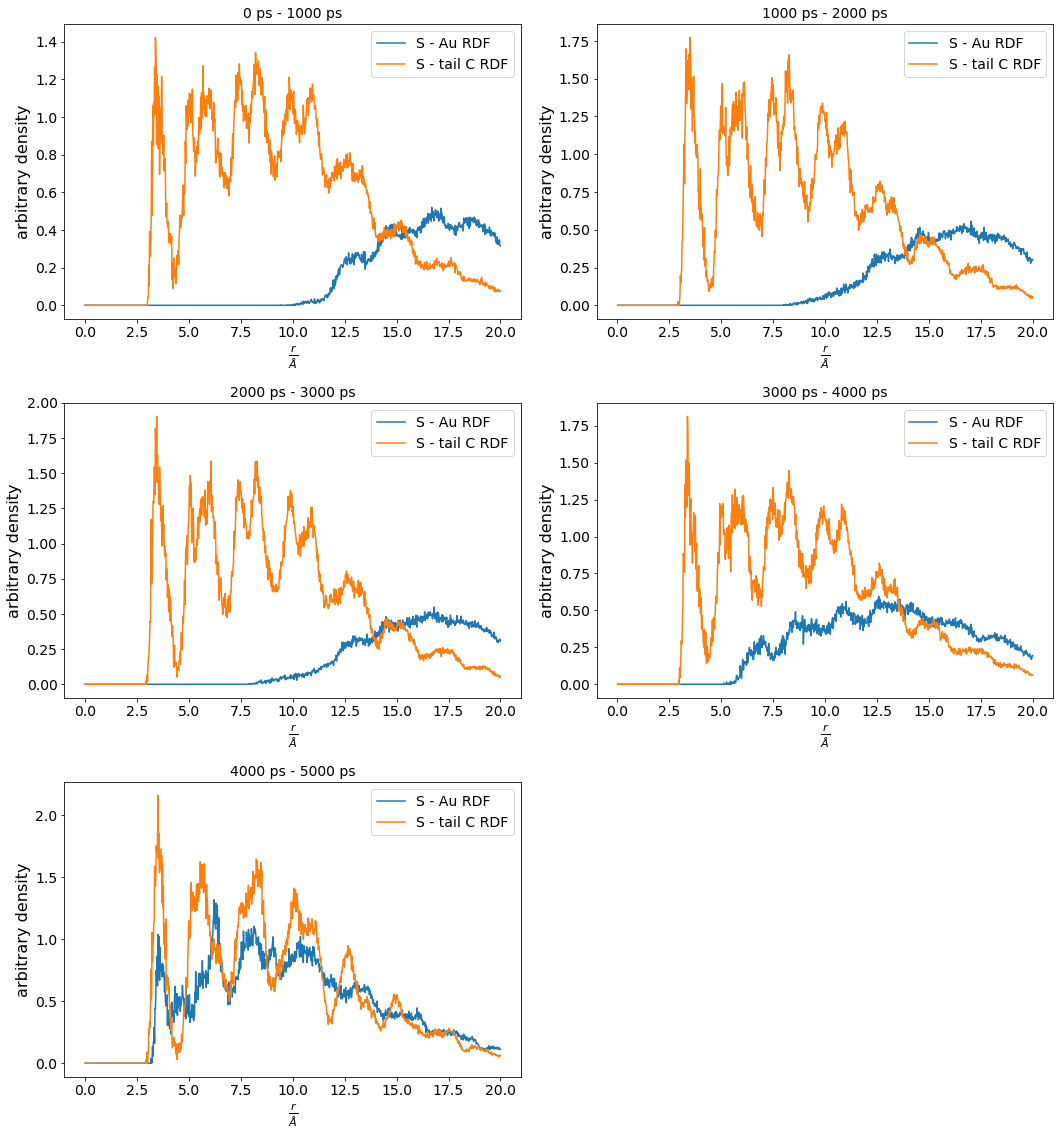

In [513]:
# code snippet for neat plotting of all time-segemtn rdfs
cols = 2
rows = np.ceil(len(rdfSulfurGoldList)/cols).astype(int)
pos = sublpotPosition(rows,cols)
fig = plt.figure(figsize=(rows*5,cols*8))

for i, (rdfSulfurGold, rdfTailCarbonGold) in enumerate(zip(rdfSulfurGoldList,rdfTailCarbonGoldList)):
    p = next(pos)
    _, ax = addSubplot(rdf_x,rdfSulfurGold, 
                       legend = "S - Au RDF", 
                       xlabel = r'$\frac{r}{\AA}$', 
                       ylabel='arbitrary density', 
                       title = "{} ps - {} ps".format(i*nSegment,(i+1)*nSegment),
                       fig = fig, pos = p)
    _, _ = addSubplot(rdf_x, rdfTailCarbonGold, 
                      legend="S - tail C RDF",
                      ax = ax, pos = p)
    
fig.tight_layout()

### 4.2. head group sulfur, tail group carbon - water RDF

In [554]:
# helper function needs:
# trajectory, segement length, indices, element tuple list
# optional: start, end, rMax, nBins

def piecewiseRDF(traj, atom_indices, element_tuples,
                nSegment = 1000, nStart = 0, nEnd = None,
                rMax = 20, nBins = 1000):

    # rMax is the rdf length (in Angstrom for LAMMPS output in real units)
    # nBins: can be understood as the number of data points on the RDF
    if not nEnd:
        nEnd = len(traj)-1

    nRDFs = len(element_tuples)

    listOfRdfLists = []
    for n in range(0,nRDFs):
        listOfRdfLists.append([])

    # actual distances
    rdf_x = (np.arange(nBins) + 0.5) * rMax / nBins

    # instead of computing an average rdf over the whole trajectory, 
    # we split the trajectory into several timespans of nSegement timestep length
    for curStart in range(nStart,nEnd,nSegment):
        print(curStart) # some progress report
        rdfObj = None
        for frame in traj[curStart:(curStart+nSegment)]:
            # the asap rdf functionality is not that convenient, but explicitely choosing
            # only the atoms we are interested in a priori, we can get exactly the rdf we want by 
            # making use of the "elements" option
            if rdfObj is None:
                rdfObj = RadialDistributionFunction(frame[atom_indices],
                                         rMax = rMax, nBins = nBins)
            else:
                rdfObj.atoms = frame[atom_indices]
            rdfObj.update()           

        # np.where facilitates the selection of according atom numbers by specifying the chemical symbol
        for n in range(0,nRDFs):
            curRdf = rdfObj.get_rdf(elements=element_tuples[n])
            listOfRdfLists[n].append(curRdf)

    return listOfRdfLists, rdf_x, rdfObj

In [548]:
# Element tuples
element_tuples = [
    ( np.where(chem_sym == 'S')[0][0], np.where(chem_sym == 'O')[0][0] ),
    ( np.where(chem_sym == 'C')[0][0], np.where(chem_sym == 'O')[0][0] ) ]

In [550]:
element_tuples # in atomic numbers

[(16, 8), (6, 8)]

In [551]:
surfactantSolventIndicesOfInterest = water_indices + [ sulfur_index ] + [ tail_carbon_index ]

In [555]:
surfactantSolventRDFs, surfactantSolventRDFx, surfactantSolventRDFobj = piecewiseRDF(
    lmp_trajectrories['npt1ns'], surfactantSolventIndicesOfInterest, element_tuples)

0
1000
2000
3000
4000


In [577]:
# code snippet for neat plotting of all time-segemtn rdfs

def plotPiecewiceRdf(rdf_x, listOfRdfLists, legend=None,
                    nSegment = 1000, nStart=0, nEnd = None, cols = 2):
    # Todo: Implement arbitrary start and end points

    
    N = 0
    for rdfList in listOfRdfLists:
        if len(rdfList) > N:
            N = len(rdfList)
            
    rows = np.ceil(N/cols).astype(int)
    
    pos = sublpotPosition(rows,cols)
    fig = plt.figure(figsize=(rows*5,cols*8))

    for i in range(0,N):
        p = next(pos)
        ax = None
        for j, rdfList in enumerate(listOfRdfLists):
            if i < len(rdfList):
                curLegend = None
                if legend and j < len(legend):
                    curLegend = legend[j]
                    
                if not ax:
                    _, ax = addSubplot(rdf_x,rdfList[i], 
                               legend = curLegend, 
                               xlabel = r'$\frac{r}{\AA}$', 
                               ylabel='arbitrary density', 
                               title = "{} ps - {} ps".format(i*nSegment,(i+1)*nSegment),
                               fig = fig, pos = p)
                else:
                    _, _ = addSubplot(rdf_x, rdfList[i], 
                              legend = curLegend,
                              ax = ax, pos = p)

    fig.tight_layout()
    return fig

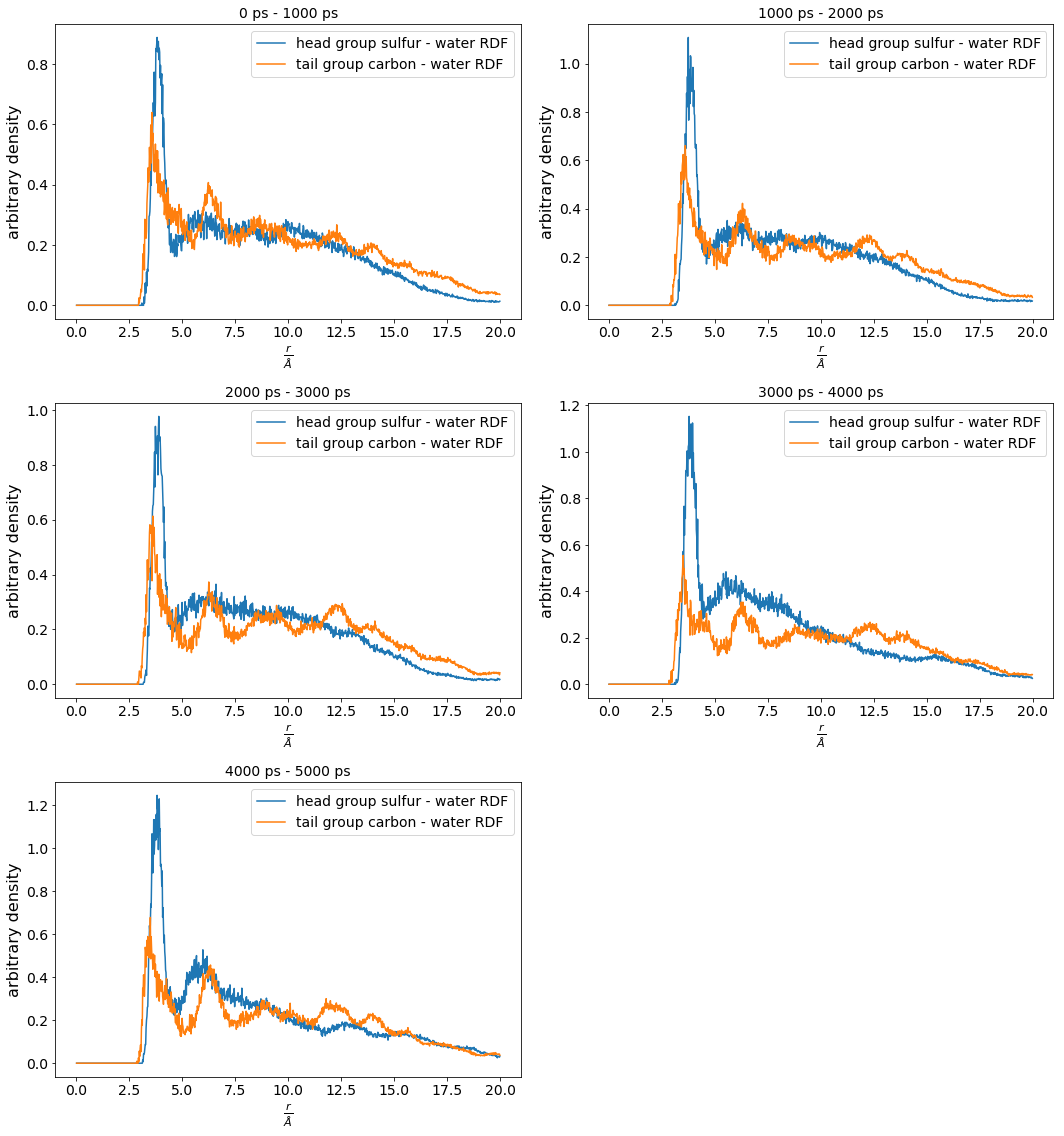

In [578]:
plotPiecewiceRdf(surfactantSolventRDFx, surfactantSolventRDFs, 
                 legend= [ "head group sulfur - water RDF", "tail group carbon - water RDF"]);

### 4.3. Sodium counterion RDF

In [568]:
# Element tuples
counterionRdf_element_tuples = [
    ( np.where(chem_sym == 'Na')[0][0], np.where(chem_sym == 'S')[0][0] ),
    ( np.where(chem_sym == 'Na')[0][0], np.where(chem_sym == 'C')[0][0] ),
    ( np.where(chem_sym == 'Na')[0][0], np.where(chem_sym == 'O')[0][0] ),
    ( np.where(chem_sym == 'Na')[0][0], np.where(chem_sym == 'Au')[0][0] ) ]

In [574]:
counterionRdf_element_tuples

[(11, 16), (11, 6), (11, 8), (11, 79)]

In [572]:
counterionRdfLabels = [ "Na+ counterion - SDS head sulfur RDF", 
                        "Na+ counterion - SDS tail carbon RDF",
                        "Na+ counterion - water oxygen RDF",
                        "Na+ counterion - surface gold RDF"]

In [569]:
counterionRdfIndicesOfInterest = water_indices + surface_indices + \
    ion_indices + [ sulfur_index ] + [ tail_carbon_index ]

In [570]:
counterionRDFs, counterionRDFx, counterionRDFobj = piecewiseRDF(
    lmp_trajectrories['npt1ns'], counterionRdfIndicesOfInterest, counterionRdf_element_tuples)

0
1000
2000
3000
4000


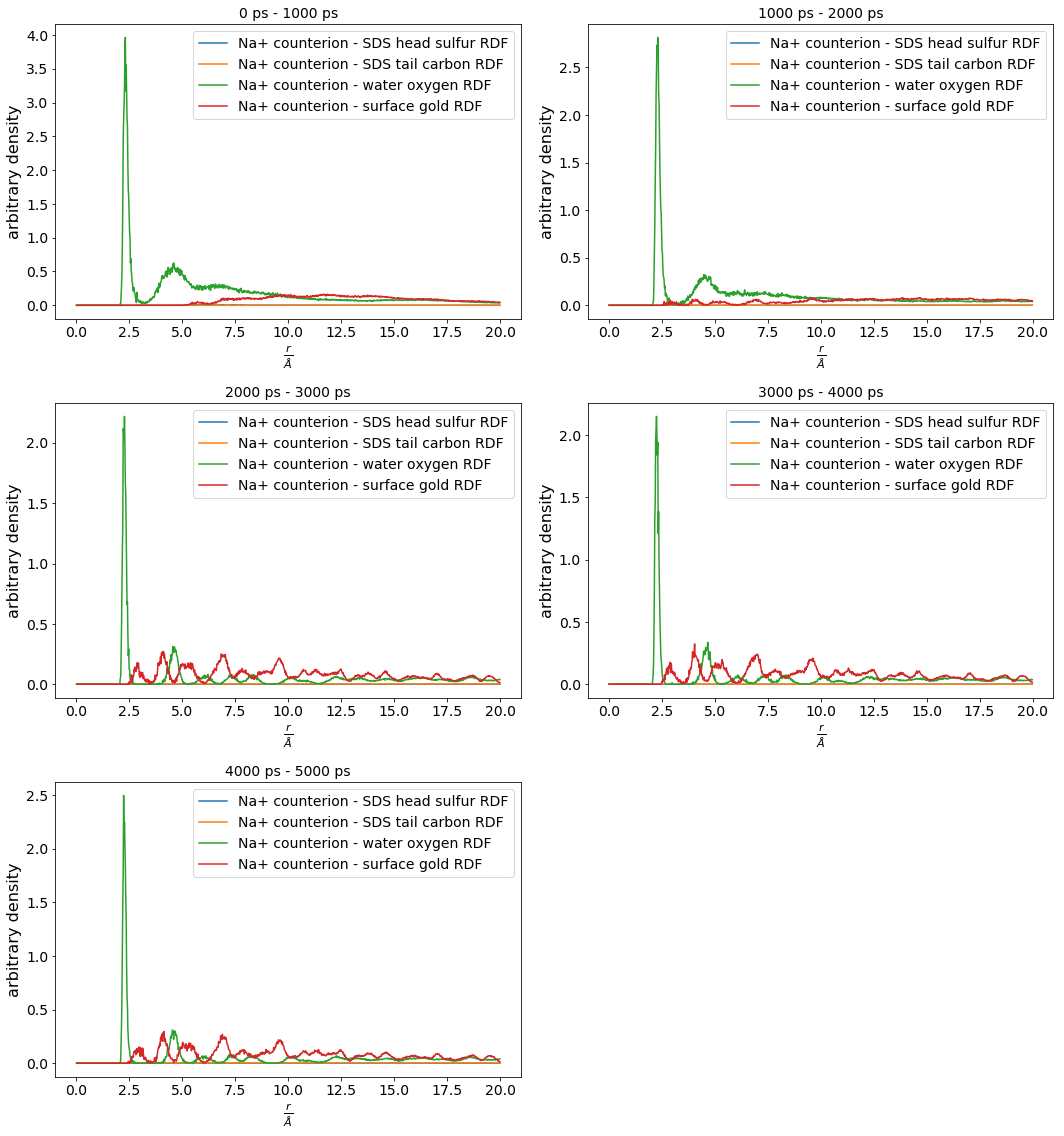

In [579]:
plotPiecewiceRdf(counterionRDFx, counterionRDFs, legend= counterionRdfLabels);

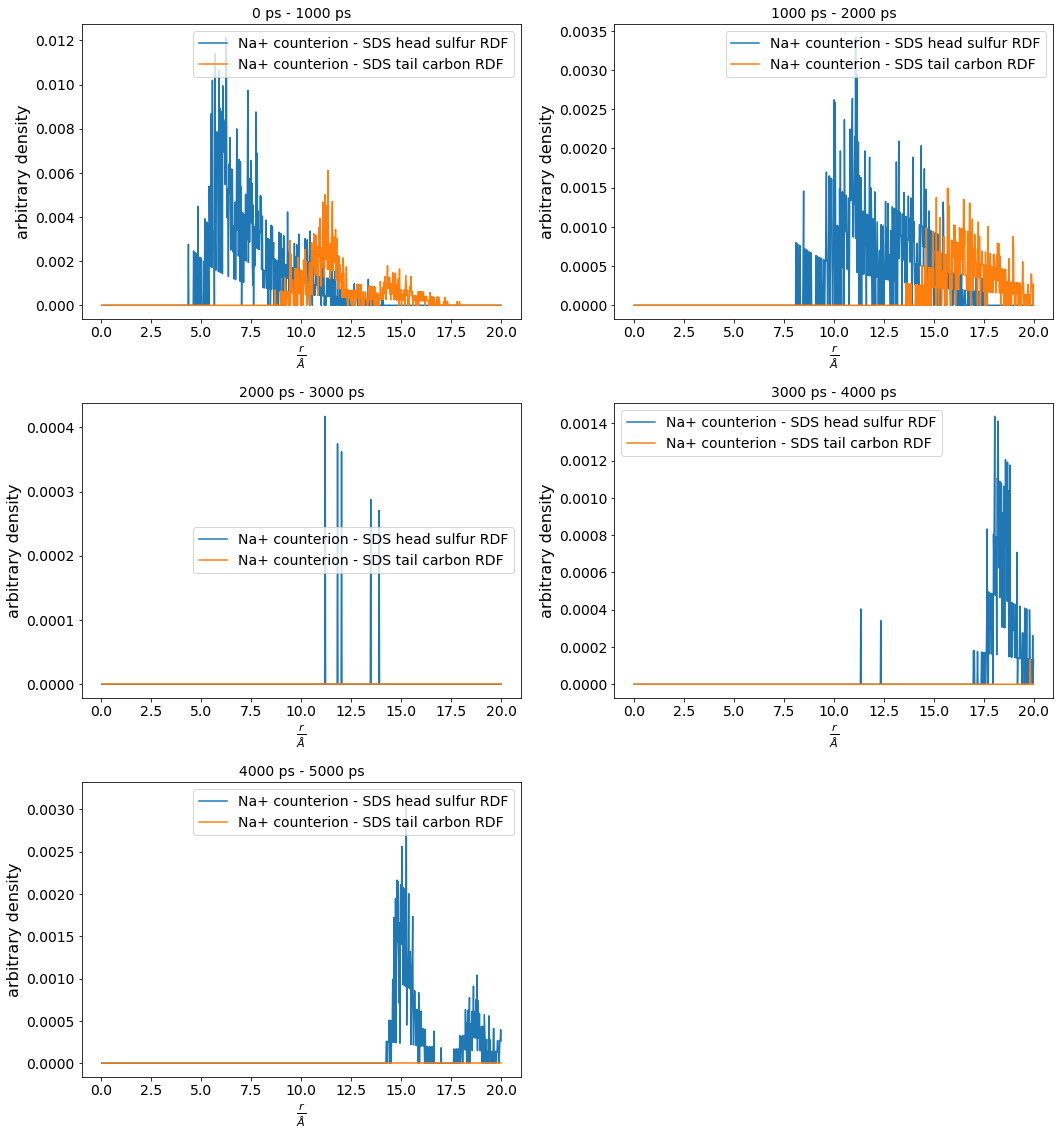

In [586]:
plotPiecewiceRdf(counterionRDFx, counterionRDFs[0:2], 
                 legend= (counterionRdfLabels[0:2]));

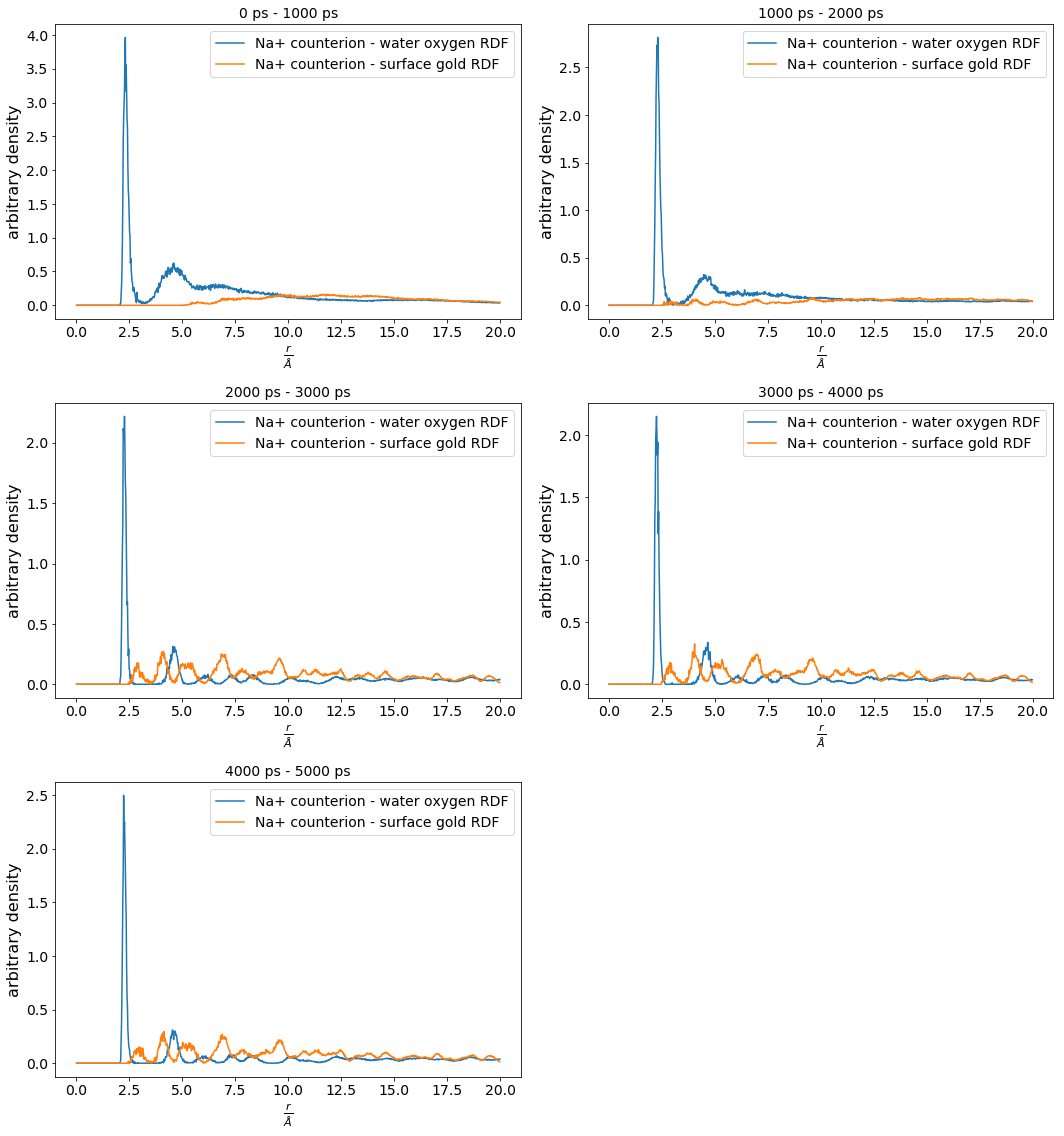

In [587]:
plotPiecewiceRdf(counterionRDFx, counterionRDFs[2:], 
                 legend= (counterionRdfLabels[2:]));

## 5. Distance analysis

### 5.1. Headgroup - gold distance
Head approaches surfaces, apparently "stepwise"

In [716]:
# helper function needs:
# trajectory, segement length, indices, element tuple list
# optional: start, end, rMax, nBins

def piecewiseAveragedDistance(traj, reference_index, atom_indices,
                nSegment = 1000, nStart = 0, nEnd = None):
  
    if not nEnd:
        nEnd = len(traj)-1

   
    N = (np.floor(nEnd - nStart)/nSegment).astype(int)
    
    t = (np.arange(nStart,nEnd,nSegment) + nSegment / 2)

    averageDistance = np.atleast_2d(np.zeros((3,N)))
         
    for i, curStart in enumerate(range(nStart,nEnd,nSegment)):
        #print(curStart) # some progress report
        curAverageDistance = np.atleast_2d(np.zeros((3,nSegment)))
        for j,f in enumerate(traj[curStart:(curStart+nSegment)]):
            curAverageDistance[:,j] = np.abs( f.get_distances(
                reference_index, atom_indices, mic=True, vector=True).mean(axis=0) )
        averageDistance[:,i] = curAverageDistance.mean(axis=1)
         
    return averageDistance, t

In [636]:
traj = lmp_trajectrories['npt1ns']

In [637]:
traj[0][surfactant_indices].get_atomic_numbers()

array([16,  8,  8, ...,  1,  1,  1])

In [638]:
averageDistanceS2Au, averageDistanceS2AuTimes = piecewiseAveragedDistance(traj,
                                reference_index=sulfur_index,
                                atom_indices=surface_indices,
                                nSegment=50)

In [639]:
len(averageDistanceS2AuTimes)

100

In [640]:
averageDistanceS2Au.shape

(3, 100)

In [641]:
distanceLabels = ['x', 'y', 'z']

Text(0,0.5,'Distance $\\frac{r}{\\AA}$')

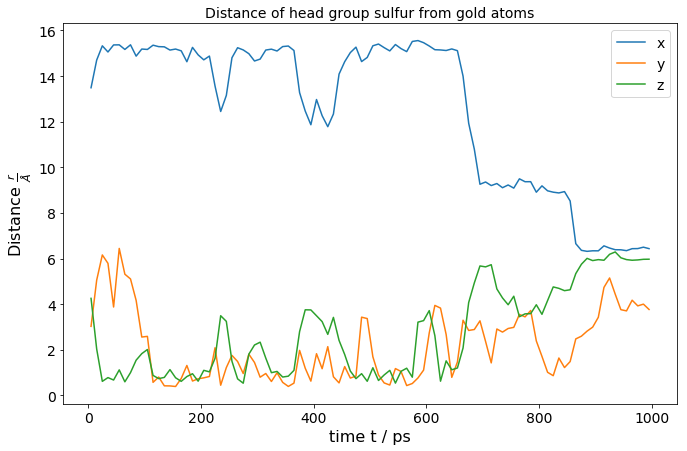

In [1028]:
distanceFig = plt.figure()
for i in range(0,3):
    plt.plot( averageDistanceS2AuTimes*0.2, averageDistanceS2Au[i,:], label= distanceLabels[i] )
plt.legend()
plt.title("Distance of head group sulfur from gold atoms")
plt.xlabel("time t / ps")
plt.ylabel(r'Distance $\frac{r}{\AA}$')

In [523]:
traj = lmp_trajectrories['npt1ns']

In [524]:
traj[0][surfactant_indices].get_atomic_numbers()

array([16,  8,  8, ...,  1,  1,  1])

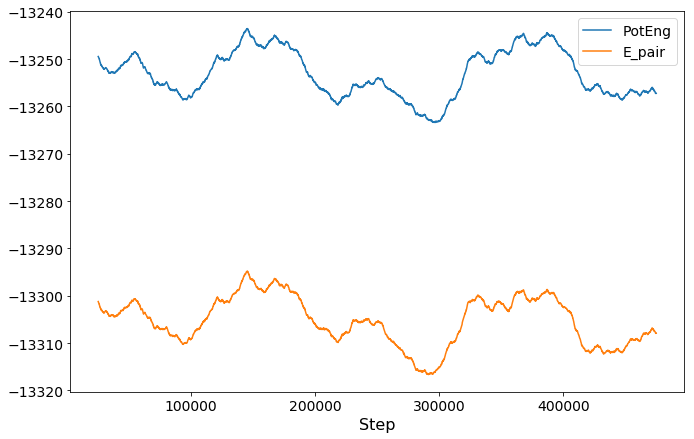

In [679]:
nptProduction_1ns_thermo_pd[["PotEng","E_pair"]].rolling(window=5000,center=True).mean().plot()

In [681]:
nptProduction_1ns_thermo_pd

TotEng     KinEng     PotEng       Temp        Press   Enthalpy  \
Step                                                                         
0      -12411.300  775.34385 -13186.644  301.17151 -2627.898500 -12971.365   
10     -12419.616  793.72663 -13213.343  308.31205   153.896370 -12387.004   
20     -12416.660  775.87342 -13192.533  301.37722  2189.406000 -11954.613   
30     -12418.765  782.24505 -13201.010  303.85218 -1215.198700 -12676.687   
40     -12434.195  789.03770 -13223.232  306.49070 -1597.146800 -12773.405   
50     -12435.122  757.45047 -13192.573  294.22108  2196.544200 -11971.923   
60     -12436.866  796.19772 -13233.064  309.27191   -89.291993 -12455.754   
70     -12452.289  770.09449 -13222.383  299.13247 -1473.806300 -12764.952   
80     -12458.311  780.47736 -13238.788  303.16555   896.128560 -12269.187   
90     -12465.461  758.78226 -13224.243  294.73839   288.183790 -12404.532   
100    -12473.789  769.83094 -13243.620  299.03010  -197.495310 -12515.494   
110    -12484.593  758.70741 -13243.301  294.70932  -846.205310 -12663.308   
120    -12493.188  771.12714 -13264.316  299.53359   592.235050 -12368.585   
130    -12498.521  754.58090 -13253.102  293.10643   414.319890 -12411.390   
140    -12509.535  759.25520 -13268.791  294.92210  -809.755060 -12680.252   
150    -12516.923  733.83129 -13250.755  285.04653   597.678950 -12391.365   
160    -12518.270  729.37223 -13247.642  283.31448   217.106320 -12472.651   
170    -12522.545  744.85867 -13267.404  289.32997  -658.846750 -12661.023   
180    -12523.140  765.96892 -13289.109  297.52995   221.697240 -12476.666   
190    -12522.336  760.86380 -13283.199  295.54693   438.223560 -12430.359   
200    -12520.042  755.14616 -13275.188  293.32600  -201.954500 -12562.531   
210    -12519.971  749.35221 -13269.323  291.07542  -293.719070 -12581.771   
220    -12516.075  760.66010 -13276.735  295.46781   682.151240 -12372.830   
230    -12512.386  751.64243 -13264.028  291.96502  -445.541220 -12606.148   
240    -12513.376  749.99178 -13263.368  291.32385   -95.283278 -12533.416   
250    -12504.639  736.91453 -13241.554  286.24417   344.908370 -12432.079   
260    -12501.182  761.29121 -13262.473  295.71296  -474.178940 -12601.128   
270    -12493.068  765.23080 -13258.298  297.24324   129.180710 -12465.858   
280    -12484.282  761.21127 -13245.493  295.68191   276.080020 -12426.154   
290    -12475.527  753.49097 -13229.018  292.68306  -342.303410 -12547.714   
...           ...        ...        ...        ...          ...        ...   
499710 -12496.249  753.34176 -13249.591  292.62510  -704.920450 -12645.585   
499720 -12490.011  734.03959 -13224.050  285.12744  1524.236100 -12168.434   
499730 -12483.210  755.94658 -13239.157  293.63691 -1266.358200 -12752.238   
499740 -12485.289  755.99777 -13241.287  293.65680  -419.576790 -12574.213   
499750 -12471.024  777.31886 -13248.343  301.93868  1590.848300 -12135.040   
499760 -12465.380  751.81605 -13217.197  292.03246 -1360.768100 -12754.549   
499770 -12464.187  791.65743 -13255.844  307.50829  -146.149460 -12495.135   
499780 -12453.255  753.50426 -13206.759  292.68823  1329.205600 -12172.502   
499790 -12448.282  791.82481 -13240.106  307.57331  -832.061250 -12624.970   
499800 -12447.349  780.24005 -13227.589  303.07337   317.324670 -12380.180   
499810 -12441.422  759.03518 -13200.457  294.83663  -255.973210 -12495.854   
499820 -12438.217  765.09739 -13203.315  297.19141   363.691860 -12361.142   
499830 -12434.794  767.00073 -13201.795  297.93074  -421.095240 -12524.226   
499840 -12434.061  774.76593 -13208.827  300.94702  -403.588840 -12519.663   
499850 -12434.688  799.26385 -13233.952  310.46290   311.024620 -12368.731   
499860 -12427.634  800.92293 -13228.557  311.10735  1626.454700 -12084.895   
499870 -12435.052  814.68496 -13249.737  316.45301 -2896.012400 -13051.675   
499880 -12448.273  800.39201 -13248.665  310.90112  1222.410600 -12190.544   
499890 -12443.244  799.67990 -132

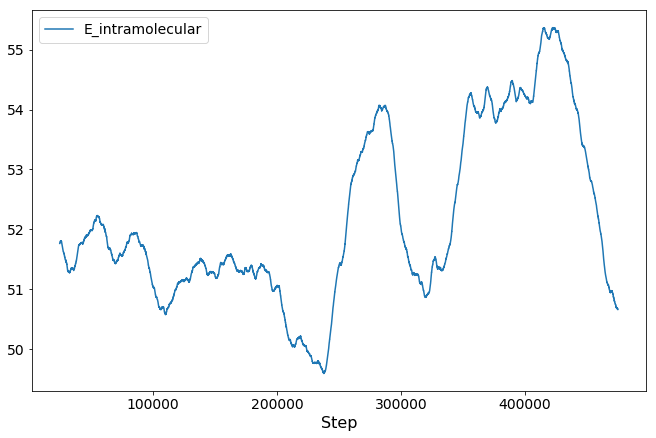

In [686]:
nptProduction_1ns_thermo_pd[["E_intramolecular"]].rolling(window=5000,center=True).mean().plot()

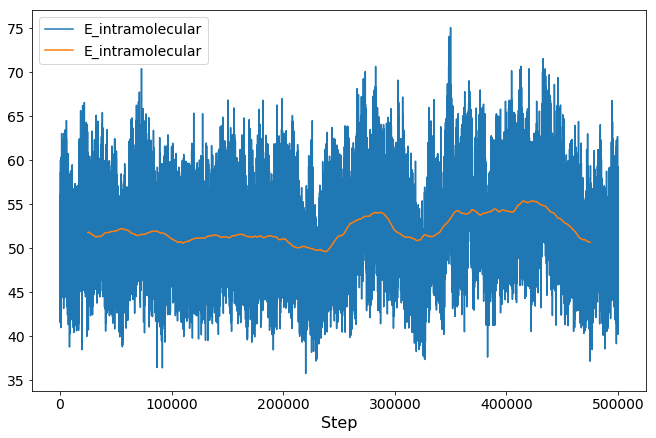

In [687]:
ax = nptProduction_1ns_thermo_pd[["E_intramolecular"]].plot()
nptProduction_1ns_thermo_pd[["E_intramolecular"]].rolling(window=5000,center=True).mean().plot(ax=ax)

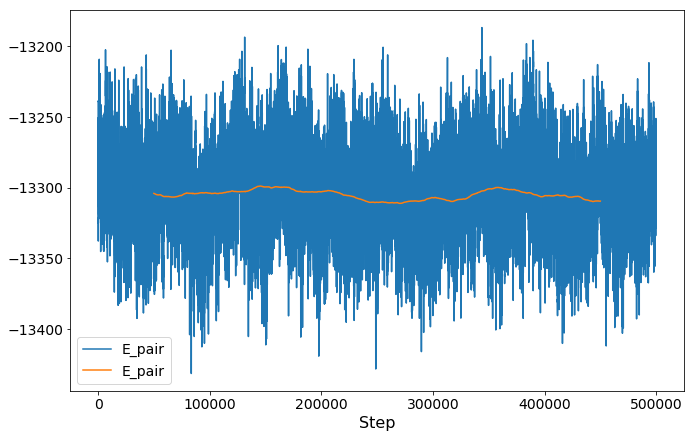

In [673]:
# running average, non-bonded energy
ax = nptProduction_1ns_thermo_pd[["E_pair"]].plot()
nptProduction_1ns_thermo_pd[["E_pair"]].rolling(window=10000,center=True).mean().plot(ax=ax)

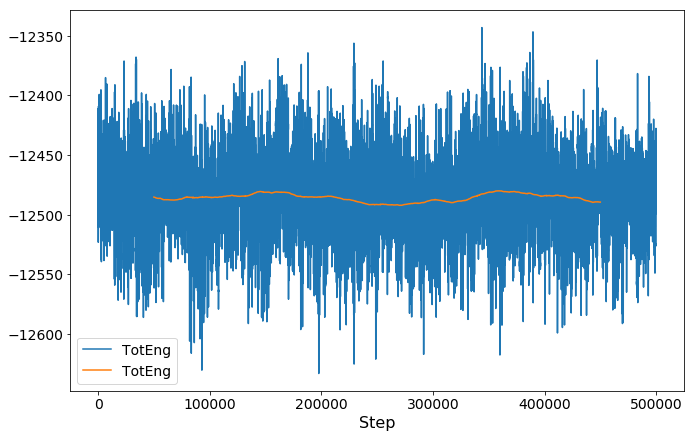

In [676]:
# running average, total energy
ax = nptProduction_1ns_thermo_pd[["TotEng"]].plot()
nptProduction_1ns_thermo_pd[["TotEng"]].rolling(window=10000,center=True).mean().plot(ax=ax)

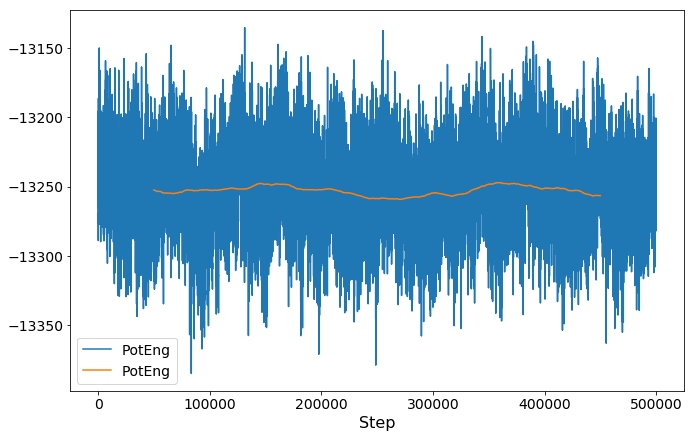

In [677]:
# running average, total energy
ax = nptProduction_1ns_thermo_pd[["PotEng"]].plot()
nptProduction_1ns_thermo_pd[["PotEng"]].rolling(window=10000,center=True).mean().plot(ax=ax)

### 5.2. Tailgroup - gold distance
Does not change

In [643]:
averageDistanceTailC2Au, averageDistanceTailC2AuTimes = piecewiseAveragedDistance(traj,
                                reference_index=tail_carbon_index,
                                atom_indices=surface_indices,
                                nSegment=50)

Text(0,0.5,'Distance $\\frac{r}{\\AA}$')

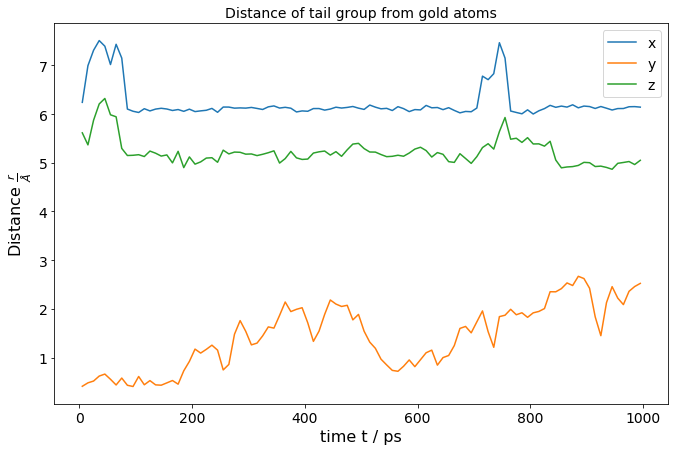

In [644]:
for i in range(0,3):
    plt.plot( averageDistanceTailC2AuTimes*0.2, averageDistanceTailC2Au[i,:], label= distanceLabels[i] )
plt.legend()
plt.title("Distance of tail group from gold atoms")
plt.xlabel("time t / ps")
plt.ylabel(r'Distance $\frac{r}{\AA}$')

### 5.3. Surface COM - Surfactant COM distance

In [719]:
def piecewiseAveragedComComDistance(traj, group1_indices, group2_indices,
                nSegment = 1000, nStart = 0, nEnd = None):
  
    if not nEnd:
        nEnd = len(traj)-1

   
    N = (np.floor(nEnd - nStart)/nSegment).astype(int)
    
    t = (np.arange(nStart,nEnd,nSegment) + nSegment / 2)

    averageDistance = np.atleast_2d(np.zeros((3,N)))
         
    for i, curStart in enumerate(range(nStart,nEnd,nSegment)):
        #print(curStart) # some progress report
        curAverageDistance = np.atleast_2d(np.zeros((3,nSegment)))
        for j,f in enumerate(traj[curStart:(curStart+nSegment)]):
            curAverageDistance[:,j] = np.abs(
                f[group1_indices].get_center_of_mass() - f[group2_indices].get_center_of_mass() )
        averageDistance[:,i] = curAverageDistance.mean(axis=1)
         
    return averageDistance, t

In [720]:
averageDistanceComCom, averageDistanceComComTimes = piecewiseAveragedComComDistance(traj,
                                surfactant_indices,surface_indices,
                                nSegment=50)

Text(0,0.5,'Distance $\\frac{r}{\\AA}$')

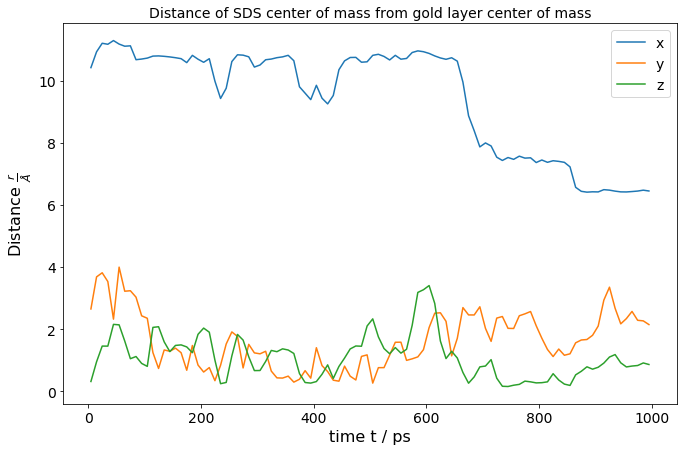

In [1031]:
for i in range(0,3):
    plt.plot( averageDistanceComComTimes*0.2, averageDistanceComCom[i,:], label= distanceLabels[i] )
plt.legend()
plt.title("Distance of SDS center of mass from gold layer center of mass")
plt.xlabel("time t / ps")
plt.ylabel(r'Distance $\frac{r}{\AA}$')

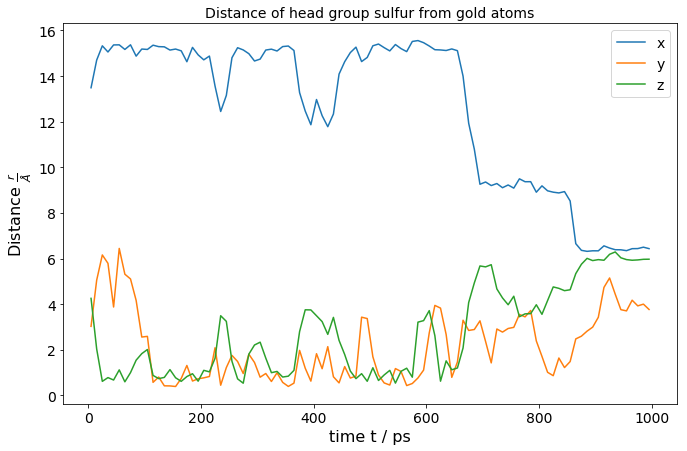

In [1032]:
# for comparison: 
distanceFig

### SDS chain length

In [1033]:
averageChainLength, averageChainLengthTimes = piecewiseAveragedDistance(traj,
                                reference_index=tail_carbon_index,
                                atom_indices=[sulfur_index],
                                nSegment=50)

In [1040]:
np.linalg.norm(averageChainLength,axis=0)

(100,)

In [1035]:
np.linalg.norm(averageChainLength,axis=0).shape

(100,)

Text(0,0.5,'Distance $\\frac{r}{\\AA}$')

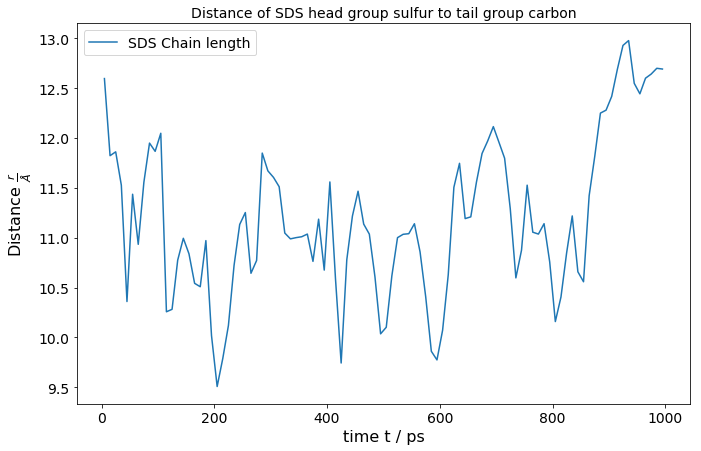

In [1041]:
plt.plot( averageChainLengthTimes*0.2, 
         np.linalg.norm(averageChainLength,axis=0), label="SDS Chain length")
plt.legend()
plt.title("Distance of SDS head group sulfur to tail group carbon")
plt.xlabel("time t / ps")
plt.ylabel(r'Distance $\frac{r}{\AA}$')

## MSD and diffusivities

In [883]:
dt

2e-15

In [884]:
T = 1e-9 # 1 ns

In [885]:
Nf = len(traj) - 1 # number of stored frames, corresponds to 1ns

In [886]:
Nf

5000

In [887]:
Ns = T/dt # number of steps

In [888]:
Ns

500000.0

In [889]:
StepsPerFrame = Ns / Nf

In [890]:
StepsPerFrame

100.0

In [891]:
TimePerFrame = StepsPerFrame*dt

In [892]:
TimePerFrame

2e-13

In [734]:
def comDisplacement(traj, atom_indices, dt = 10):
    """Evaluates the displacement of an atom group's COM 
    between each frame of the trajectory and another frame 'dt' indices later."""
    N = len(traj) - dt

    displacement = np.atleast_2d(np.zeros((3,N)))

    for j in range(N):
        reference_com   = traj[j][atom_indices].get_center_of_mass()
        dt_com           = traj[j+dt][atom_indices].get_center_of_mass()
        displacement[:,j] = np.abs(dt_com - reference_com)         
    
    return displacement

In [879]:
def evaluateDisplacement(displacement, dt = 10, window = 500):
    """Evaluates an anisotropic displacement vector and also computes diffusivities
    based on Enstein relation"""
    isotropic_displacement = np.linalg.norm(displacement,axis=0)

    time = np.arange( len(isotropic_displacement) )* TimePerFrame/ps

    rows = 3
    cols = 1
    
    fig = plt.figure(figsize=(8*cols, 5*rows))
    
    pos = subplotPosition(cols=cols,rows=rows)
    
    p = next(pos)
    _, ax = addSubplot(time[:-window+1], running_mean( isotropic_displacement,window), 
            title = "{:.2f} ps displacement".format(dt*TimePerFrame/ps), 
            xlabel = "time t / ps", ylabel= r'displacement $\frac{r}{\AA}$',
            legend = 'isotropic', fig = fig, pos = p)

    for i in range(0,3):
        addSubplot(time[:-window+1], 
                   running_mean(displacement[i,:], window), 
                   legend = distanceLabels[i], ax = ax, pos = p)
        
    p = next(pos)
    _, ax = addSubplot(time[:-window+1], running_mean( isotropic_displacement**2 / 3.0, window), 
            title = "{:.2f} ps MSD".format(dt*TimePerFrame/ps), 
            xlabel = "time t / ps", ylabel= r'MSD $\frac{r^2}{\AA^2}$',
            legend = 'isotropic', fig = fig, pos = p)

    
    for i in range(0,3):
        addSubplot(time[:-window+1], 
                   running_mean(displacement[i,:]**2, window), 
                   legend = distanceLabels[i], ax = ax, pos = p)
        
        
    # Einstein relation and converion to SI units
    D    = 1.0/2.0 * displacement**2 * AA**2 / (dt*TimePerFrame) 
    Diso = 1.0/6.0 * isotropic_displacement**2 * AA**2 / (dt*TimePerFrame) 
    
    p = next(pos)       
    _, ax = addSubplot(time[:-window+1], running_mean( Diso, window), 
            title = "diffusivities from {:.2f} ps MSD".format(dt*TimePerFrame/ps), 
            xlabel = "time t / ps", ylabel= r'D $\frac{m^2}{s}$',
            legend = 'isotropic', fig = fig, pos = p)

    
    for i in range(0,3):
        addSubplot(time[:-window+1], 
                   running_mean(D[i,:], window), 
                   legend = distanceLabels[i], ax = ax, pos = p)
        
    fig.tight_layout()
    
    return fig

In [872]:
displacement10ps = comDisplacement(traj, surfactant_indices, dt=50)

In [829]:
displacement1ps = comDisplacement(traj, surfactant_indices, dt=5)

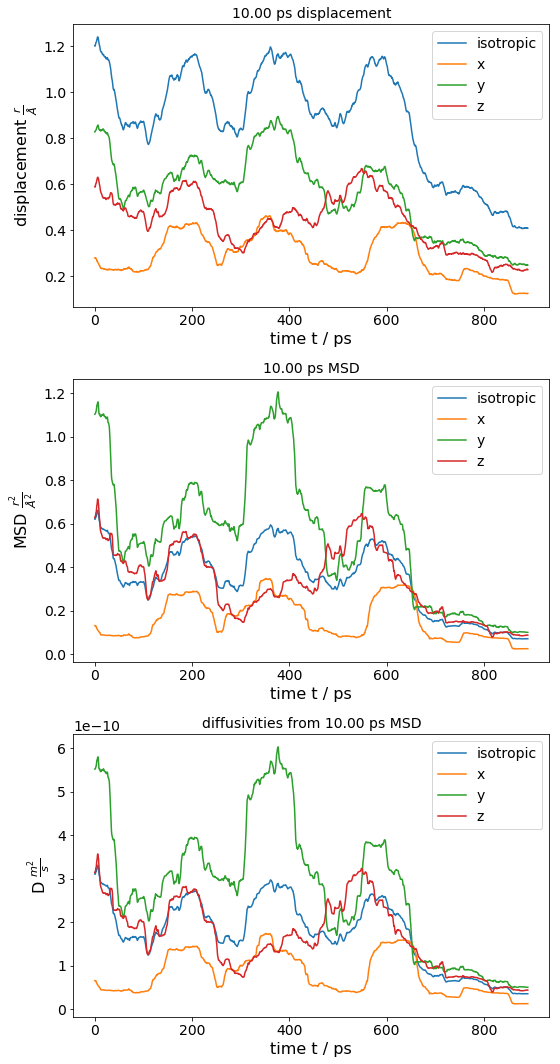

In [880]:
evaluateDisplacement(displacement10ps, dt=50);

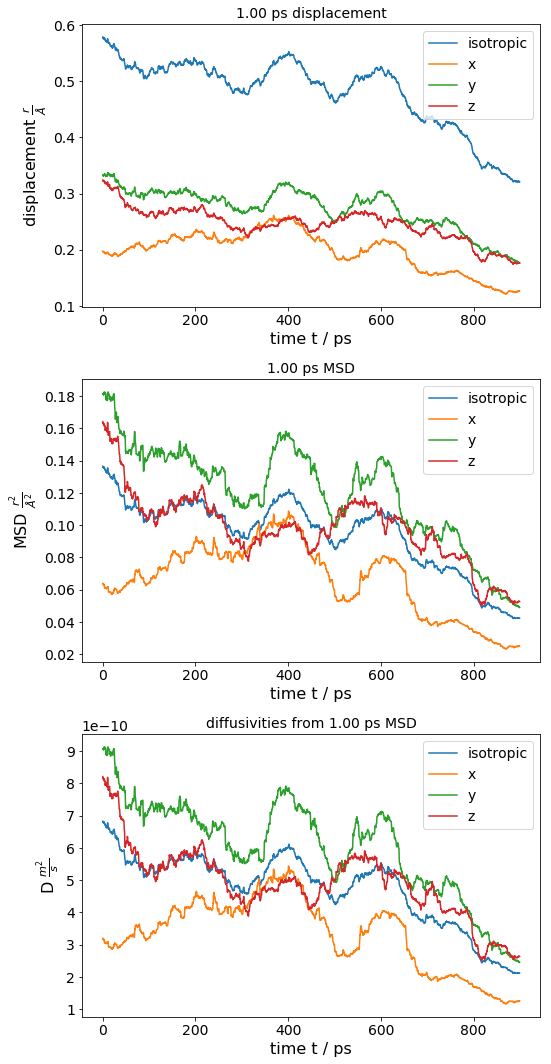

In [881]:
evaluateDisplacement(displacement1ps, dt=5);

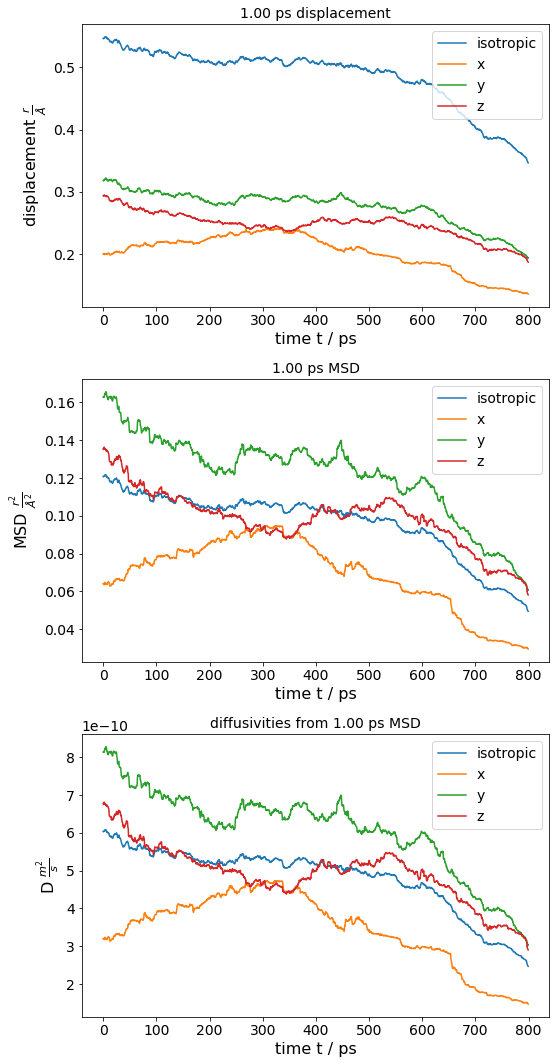

In [882]:
evaluateDisplacement(displacement1ps, dt=5, window=1000);